In [1]:
from eda_import import *

In [2]:
from misc.utils import sizeof_fmt

In [3]:
print(datetime.datetime.now().date())

2018-05-09


In [6]:
df0 = pd.read_csv('./metadata/LATEST_MANIFEST.final.tsv.gz', low_memory=False, sep='\t', compression='gzip')
df1 = pd.read_csv('data/RNAseq_FastQC.csv.gz', compression='gzip')
df2 = pd.read_csv('data/GCS_listing_27apr2016.csv.gz', compression='gzip')

In [7]:
df2['pretty_size'] = df2.objectSizeBytes.apply(sizeof_fmt)

In [8]:
df2.head(1)

,CGHubAnalysisID,AliquotBarcode,AliquotUUID,GCSobject,objectSizeBytes,pretty_size
0,00007994-abeb-4b16-a6ad-7230300a29e9,TCGA-AA-3495-01A-01R-1410-07,c18465ae-447d-46c8-8b54-0156ab502265,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_1620885.c18465ae-447d-46c8-8b54-0156ab502265.sorted_genome_alignments.bam,1972948726,1.8GB


In [9]:
print(df0.shape)
print(df1.shape)
print(df2.shape)

(128399, 37)
(22408, 174)
(83451, 6)


In [10]:
df0.analysis_id.unique().shape

(128189,)

In [11]:
ndf = df1.merge(df0, left_on='CGHub_analysisID', right_on='analysis_id')
ndf = ndf.merge(df2, left_on=['CGHub_analysisID', 'AliquotBarcode'], right_on=['CGHubAnalysisID', 'AliquotBarcode'])

In [12]:
assert ndf.analysis_id.unique().shape[0] == 11340

In [13]:
assert ndf.shape == (22408, 216)

## Verified that not a single poor read was found

In [14]:
ndf.numPoorSeq.value_counts()

0    22408
Name: numPoorSeq, dtype: int64

In [15]:
ndf.FastQC_html_url.head(1)

0    https://storage.cloud.google.com/isb-cgc-open/tcga-qc/KIRP/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/00065a62-5e18-4223-a884-12fca053a109-140516_UNC12-SN629_0369_AC4GGKACXX_GGCTAC_L002_1_fastqc.html
Name: FastQC_html_url, dtype: object

In [16]:
ndf.PerBaseSeqQual.value_counts()

pass    20427
fail    1945 
warn    36   
Name: PerBaseSeqQual, dtype: int64

Add some handy columns

In [17]:
ndf['handy_disease_names'] = ndf.apply(lambda x: '{0}: {1}'.format(
        x.disease, ' '.join([_.capitalize() for _ in x.disease_name.split()])), axis=1)

In [18]:
# Drop columns that are not interested at the moment
cols = ndf.columns.values
cols_to_drop = [_ for _ in cols if re.search('^Per|^PBSQ|^PSQC|^PBSC|^PSGCC|^PBNC|^SLD_|^Dedup_|^OverRepSeq|^Kmer_', _)]
ndf.drop(cols_to_drop, axis=1, inplace=True)

In [19]:
ndf[ndf.filename.str.contains('UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz')]

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names
12268,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,TCGA-P6-A5OF-01A-11R-A29S-07,130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1_fastqc.zip,pass,72562760,0,48,48,1,49,pass,fail,38.184442,warn,pass,fail,TCGA,TCGA-P6-A5OF-01A-11R-A29S-07,ACC,ADRENOCORTICAL CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6.513721e+09,b662e7d30ed31b4e9b815bf074dd0d63,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,888a7158-2319-4563-849b-573705c72ab7,42e0c347-e8d1-4490-a6bb-8a43e5a21013,P6,NaN,2013-09-25,2013-09-25,2013-09-25,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6513721325,6.1GB,ACC: Adrenocortical Carcinoma
12269,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,TCGA-P6-A5OF-01A-11R-A29S-07,130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2_fastqc.zip,pass,72562760,0,48,48,1,49,pass,fail,39.669957,pass,pass,fail,TCGA,TCGA-P6-A5OF-01A-11R-A29S-07,ACC,ADRENOCORTICAL CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6.513721e+09,b662e7d30ed31b4e9b815bf074dd0d63,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,888a7158-2319-4563-849b-573705c72ab7,42e0c347-e8d1-4490-a6bb-8a43e5a21013,P6,NaN,2013-09-25,2013-09-25,2013-09-25,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6513721325,6.1GB,ACC: Adrenocortical Carcinoma


## Centers that produce RNA-Seq data

In [20]:
ndf.library_type.unique()

array(['RNA-Seq'], dtype=object)

In [21]:
ndf[ndf.library_type == 'RNA-Seq'].center.value_counts()

UNC-LCCC    19238
BCCAGSC     2830 
BI          340  
Name: center, dtype: int64

In [22]:
unc_df = ndf[ndf.center == 'UNC-LCCC']
gsc_df = ndf[ndf.center == 'BCCAGSC']
bi_df = ndf[ndf.center == 'BI']

#### By disease

In [23]:
unc_df.handy_disease_names.value_counts()

BRCA: Breast Invasive Carcinoma                                           2512
KIRC: Kidney Renal Clear Cell Carcinoma                                   1236
LUAD: Lung Adenocarcinoma                                                 1202
THCA: Thyroid Carcinoma                                                   1144
HNSC: Head And Neck Squamous Cell Carcinoma                               1132
PRAD: Prostate Adenocarcinoma                                             1116
LUSC: Lung Squamous Cell Carcinoma                                        1110
LGG: Brain Lower Grade Glioma                                             1068
SKCM: Skin Cutaneous Melanoma                                             946 
COAD: Colon Adenocarcinoma                                                900 
BLCA: Bladder Urothelial Carcinoma                                        866 
LIHC: Liver Hepatocellular Carcinoma                                      848 
UCEC: Uterine Corpus Endometrioid Carcinoma         

In [24]:
gsc_df.handy_disease_names.value_counts()

STAD: Stomach Adenocarcinoma             968
OV: Ovarian Serous Cystadenocarcinoma    858
LAML: Acute Myeloid Leukemia             608
ESCA: Esophageal Carcinoma               396
Name: handy_disease_names, dtype: int64

In [25]:
bi_df.handy_disease_names.value_counts()

GBM: Glioblastoma Multiforme    340
Name: handy_disease_names, dtype: int64

#### By sample type

In [26]:
unc_df.sample_type_name.value_counts()

Primary solid Tumor         16997
Solid Tissue Normal         1373 
Metastatic                  786  
Recurrent Solid Tumor       58   
Additional - New Primary    22   
Additional Metastatic       2    
Name: sample_type_name, dtype: int64

In [27]:
gsc_df.sample_type_name.value_counts()

Primary solid Tumor                                2106
Primary Blood Derived Cancer - Peripheral Blood    608 
Solid Tissue Normal                                98  
Recurrent Solid Tumor                              16  
Metastatic                                         2   
Name: sample_type_name, dtype: int64

In [28]:
bi_df.sample_type_name.value_counts()

Primary solid Tumor      314
Recurrent Solid Tumor    26 
Name: sample_type_name, dtype: int64

#### by platform full names

In [29]:
ndf.platform_full_name.value_counts()

Illumina HiSeq 2000             20968
Illumina Genome Analyzer IIx    736  
Illumina Genome Analyzer II     648  
Illumina HiSeq 2500             56   
Name: platform_full_name, dtype: int64

In [30]:
unc_df.platform_full_name.value_counts()

Illumina HiSeq 2000            18590
Illumina Genome Analyzer II    648  
Name: platform_full_name, dtype: int64

In [31]:
gsc_df.platform_full_name.value_counts()

Illumina HiSeq 2000             2038
Illumina Genome Analyzer IIx    736 
Illumina HiSeq 2500             56  
Name: platform_full_name, dtype: int64

In [32]:
bi_df.platform_full_name.value_counts()

Illumina HiSeq 2000    340
Name: platform_full_name, dtype: int64

### Some verification

In [33]:
for col in ['study', 'library_type', 'state', 'file_type']:
    print(ndf[col].value_counts())
    print

TCGA    22408
Name: study, dtype: int64
RNA-Seq    22408
Name: library_type, dtype: int64
Live    22408
Name: state, dtype: int64
fasta    22408
Name: file_type, dtype: int64


#### Drop analysis ids with inconsistent read length

In [34]:
ndf.delLength.value_counts()

1     22407
45    1    
Name: delLength, dtype: int64

In [35]:
ndf[ndf.delLength == 45]

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names
3462,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,61YETAAXX_1_ATCACG_2.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.zip,pass,83121778,0,6,50,45,47,warn,fail,0.410745,fail,pass,warn,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,6924e520152b16158c3ea24ef20550af,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,ab60901b-d2ad-401a-9742-52df35ce1de0,40168b34-bbfe-4ee2-b7b5-2e33fbf64a18,AB,SRS131131,2014-05-13,2014-05-13,2014-05-13,Live,03,T,Illumina Genome Analyzer IIx,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6494423040,6.0GB,LAML: Acute Myeloid Leukemia


#### Take a look at its odd read length distribution


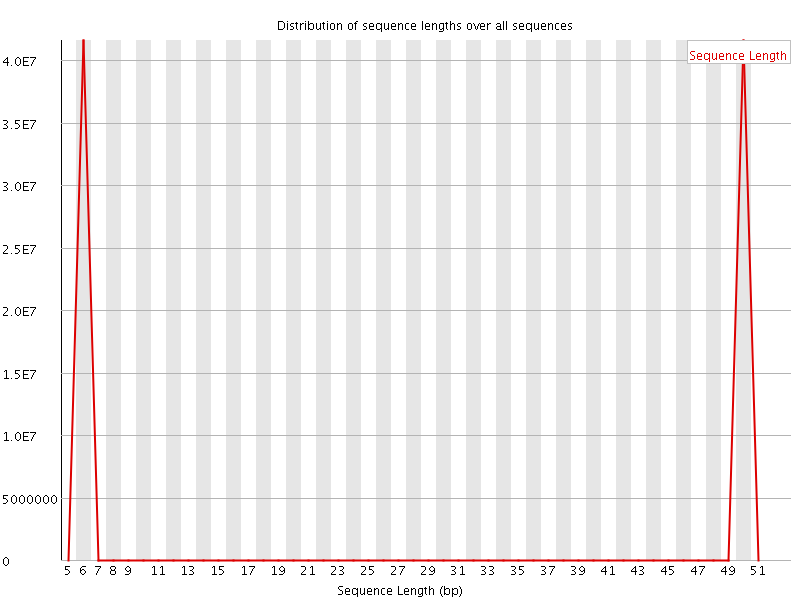

In [36]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAIAAAAVFBUnAABOh0lEQVR42u3dDbDOdf7/8ZOhVUpJWT9bS8la5efHIqWUUSnbRu1KRnMGqzYrozX+yojWKD9jmZK2zdYYUqtYJaGMUkrWT2ukG7Fxbp3LcX+THLeH//vNdpy9rutc1/fm8/l8v4fne3bM2cv3+zjH9+3t/eq6zTlBURRFURRFGa0cLgFFURRFURQBi6IoiqIoioBFURRFURRFwKIoiqIoiqIIWBRFURRFUQQsiqIoiqIoAhZFURRFURRFwKIoiqIoiiJgURRFURRFEbAoiqIoiqIoAhZFURRFURQBi6IoiqIoioBFURRFURRFwKIoiqIoiqIIWBRFURRFUQQsiqIoiqIoAhZFURRFURRFwKIoiqIoiiJgURRFURRFEbAoiqIoiqIoAhZFWR2h/6yk3woGhjk9zIle/qRnQL+qhWnjxzsD2kdRBCyKOosCVoBd6+UwX+vQ9u48Y3azqT9IZYeARVEUAYuirC/stPus8l1cSXd3Vb4x9fTU+8ZSv04Lpn7ftN+uqj9UEpjh+LTfIu39eVX9GcP82B6/u6nv4qWD3n+Sqrrm5S9AVXKGvzDVuoOZLyZFEbAo6mwMWBmOSV05SbEma24LcGPmjet3N/s9PUMW9Ptje/zuXuKvx+/i/U+UOQp4/IN7+Yvhnc3a7th2kFxFEbAoioB1ImQOqOosgwHLYwSxFLAs/VlMBayQl9FNwPL1N9N4wHLfQQIWRcCiKAJW9v/oP5MCVto/Wuqz/v3+WTILmddzVa85MPJdvAesAHc1peYqLxczwxXwnpLj30EeH6QIWBRFwMrx9VvVPWAFuJvE79INdv9HyJ8zfMDy+43SBiwvf+U8/vwe71SLcwfJWBQBi6LO0oDlcdd6DFhZ92V1DFhV3bkS/4CV9YKfJQErwg4SsCgCFkWdRQEr6/tgZf3dDLdneEXVCc/PR/aeBryclfnIE+kepTpRxWvQMvxZvDzAdCLja9A8BgXv3+WE/+d0e3+pZobAHfghQo9xLf4d5CWEFAGLoijKUyrlJ6eDFEXAoiiKOnvXc+a7xOggRVEELIqiKIqiKAIWRVEURVEUAYuiKIqiKIoiYFEURVEURRGwKIqiKIqiCFgURVEURVEELIqiKIqiKIqA5bP2PPtsyS237HnuOf4GUBRFURS7m4D1w8/t523utqRU/g03bMrJKejYMfW3fP0YW/wUMjIyMjJyPOVlVKAiYCVXwcmAJTGLMUNGRkZGRs6cFai0RcBKdw/W9dfrPVgELGRkZGRkZAIWActswJJfGTNkZGRkZGQCFgHLUMC67joNWB06MGbIyMjIyMgELAKWoYDVrp0GrPbtGTNkZGRkZGQCFgHLUMD6xS80YP3iF4wZMjIyMjIyAYuAZSZgFbRurQGrdWvGDBkZGRkZmYBFwDJ0D1bLlhqwWrVizJCRkZGRkQlYBCxDAeuaazRgXXMNY4aMjIyMjEzAImAZClg/+5kErLzmzRkzZGRkZGRkAhYBy0zAyrvySg1YV13FmCEjIyMjI1fOCrIfK/5XLSKB1Z8zA07AShewfvpTDVg//SljhoyMjIyMXJEVqkuoshqwKoMELJ8Bq2FDDVj/9V+MGTIyMjIyctaAlfY+rco3VvxWVekkVag4MQOb4btnzkABvl3lA5L+OGm/OwErXcC69FINWJdeypghIyMjIyMnPUTo5R6d1ADk/eAMZ3n87pkDVrBv5+uPRsBK/xdr04UX6iWrW5cxQ0ZGRkZGTsoKae/7yZyEggWsrKzZgBXmRgKWt4BVu7b+7aldmzFDRkZGRkZOmxWS7vtJ+9iZrzurMgiZA1bm5917PCUWAStzfMk5Wam3VK6qboxLwKpRQy96jRqMGTIyMjIyctaAlTXW+I1Nwe7BSlseT4k+YGUOQxW/VfkYL3EnPgErUVRUkWoTxcWMGTIyMjIyAStMwKrq6U3VKGBlva8rbMCquPPJS6xJG7YcpKuwAWvjRn2G+6mAtXEjY4aMjIyMTMBKfXCtqgfdUm+sKm+lPTjY6w0zP0SYFvf17fzem+UvYGUNTMECVo6FN9VYGKLemzVLr+Y558iv773++kKKoiiKOrsr/Du5V8c30Ar5R/AasLw85JchYGV4rpWNgBXqHqw1a/QerJNPw0p8/jn/HYOMjIyMzD1YZ2fACvO29T4CVtbnpAe4ByvHzhUPE7BKVq7UgFWzpvwqXzNmyMjIyMgErBOUpYDlJb6cIQFr2TINWOeeqwHr448ZM2RkZGRkAhYVoIwFrBM+X0WYY+0Ow1ABa8kSDVgn3wpLvmbMkJGRkZGRYy4b3N1uKnswSvucKi/vgxXbgLV5wQJtUp068qt8zTAgIyMjIyPHXDa4u6MMWPGvUAFr7lxtUt262qQ332QYkJGRkZGR4x6wzO1uApa1gHXybRryLrlEmzRrFsOAjIyMjIwc94BlbncTsKwFrOnTtUmXXaZNmjGDYUBGRkZGRo57wDK3uwlYtgJW8dSp0p78Ro3kV/maYUBGRkZGRo65bHB3E7CsBawpU7RJjRtrk6ZMYRiQkZGRkZHjHrDM7W4ClrWANXGiNunqq7VJkyYxDMjIyMjIyHEPWOZ2NwHLWsAaN06b1KKFNmncOIYBGRkZGRk57gHL3O4mYNkKWEWjR2uT/ud/5NeiJ59kGJCRkZGRkWMuG9zdBCxrAevxx6U9Be3ba5NGjGAYkJGRkZGR4x6wzO1uApa1gDV0qDbpppu0SUOHMgzIyMjIyMhxD1jmdjcBy1rAGjRIm3TrrfJr4aBBDAMyMjIyMnLcA5a53U3AshWwCgcM0Pb88pf664ABDAMyMjIyMnLMZYO7m4BlLWDl5mp7fv1r/TU3l2FARkZGRkaOe8Ayt7sJWNYCVq9e2p4+ffTX++9nGJCRkZGRkeMesMztbgKWrYBV0KOHPkXu5J2N8jXDgIyMjIyMHHPZ4O4mYFkLWHfeqU165BFtUrduDAMyMjIyMnLcA5a53U3AshawunTRJv2//6dN6tKFYUBGRkZGRo57wDK3uwlY1gLWqXfRePLJU++owTAgIyMjIyPHPWCZ290ELFsBK79dO/0kowkT9E3327dnGJCRkZGRkWMuG9zdBCxrAatVK2nP5ilTtEmtWjEMyMjIyMjIcQ9Y5nY3ActawGreXJs0bZo26ec/ZxiQkZGRkZHjHrDM7W4Clq2AldekibSnZPZs+TXvyisZBmRkZGRk5JjLBnc3ActawGrUSJu0aJE2qVEjhgEZGRkZGTnuAcvc7iZgWQtY9etrkz7+WJt06aUMAzIyMjIyctwDlrndTcCyFrAuvFDak1i9Wpt04YUMAzIyMjIyctwDlrndTcCyFbA2nXuutGfLt9/Kr/I1w4CMjIyMjBxz2eDuJmDZCViJhPbmnHP+/YV0i2FARkZGRkaOs2x0dxOw7ASswsKK8PvvOFxYyDAgIyMjIyPHVza6uwlYVgJWYsOGiodv//2A7r/+xTAgIyMjIyPHVja7uwlYdgLWl19WvADh1EsS5BaGARkZGRkZOb4By+juJmDZCVinXoBw8i00Tr2phtzCMCAjIyMjI8c3YBnd3QQsOwFrxYqKN4E99bawiX/8g2FARkZGRkaOb8AyursJWFYCVsmHH1Z8jNGpDzaSWxgGZGRkZGTk2MpmdzcBy07Aeu+9ig/iPvXR3CWLFzMMyMjIyMjI8Q1YRnc3ActOwJo/X5vUvr02qV07bdI77zAMyMjIyMjI8Q1YRnc3ActKwNo8Z440puCmm+Rr+VW+llsYBmRkZGRk5NjKZnc3ActOwHr1VW3Srbdqk7p00Sa99hrDgIyMjIyMHN+AZXR3E7DsBKxp07RJ3bppk+68U5s0bRrDgIyMjIyMHN+AZXR3E7DsBKwXX9Qm9eihTerRQ5v04osMAzIyMjIycnwDltHdTcCyErCKn31WGlN4//3ydWGvXvJ18eTJDAMyMjIyMnJsZbO7m4BlJ2BNmKBNys3VJuXmapMmTGAYkJGRkZGR4xuwjO5uApadgDV2rDZpwABt0oAB2qSnnmIYkJGRkZGR4xuwjO5uApadgDVqlDZp0CD5umjQIG3SqFEMAzIyMjIycnwDltHdTcCyErCKhg+XxhQNHapfDx2qXw8fzjAgIyMjIyPHVja7uwlYdgLWkCHamBEj9OvHH9evH32UYUBGRkZGRo5vwDK6uwlYdgLWwIHamCef1K9Hj9avBw5kGJCRkZGRkeMbsIzubgKWnYDVv78+djtunD6mO26cPqbbvz/DgIyMjIyMHN+AZXR3E7CsBKzCPn20SZMmaZMmTtQmPfAAw4CMjIyMjBxb2ezuJmDZCVg9e2qTpkzRJk2Zok3q2ZNhQEZGRkZGjm/AMrq7CVh2Atbdd2uT/vpXbdLUqdqk7t0ZBmRkZGRk5PgGLKO7m4BlJWAVdO2qn2E0Y4Z8vXn6dP1so65dGQZkZGRkZOTYymZ3NwHLTsDq3FmbNGuWNmnWLG1S584MAzIyMjIycnwDltHdTcCyE7BuuEGb9Oab2qS5c7VJHTsyDMjIyMjIyPENWEZ3NwHLTsBq21abtGCBNmnBAm1S27YMAzIyMjIycnwDltHd7Tpg5VSqDLEm7WE5KVXVjZEHrPxrr5XGlCxZIl/Lr/J1fsuWDAMyMjIyMnJsZbO7O8p7sKqKL35vDxyJLAasZs20SR9/rE1atkyb1KwZw4CMjIyMjBzfgGV0d59RActsugoVsBo31iatXKlNWrlSm9S4McOAjIyMjIwc34BldHdHFrC8PEToK+4YT1dSC4PWhksukcYsnjlTvl78yivy9Yb69RdSFEVRFBXXiu3u9hqwvD9TKumwzM+1shGwAt+DlVevnjQmsW6dfJ34+mv5Wm7hvzaQkZGRkZFjK5vd3XG8B6uqwzLf6WXl5w4csM4/X5u0caM2aeNGbVKdOgwDMjIyMjJyfAOW0d0dx+dgnQkBq2ZNbVJxsTapqEibVKsWw4CMjIyMjBzfgGV0d8c6YKU+ROgyXQUPWCUl0pVNNWpU3CBfyy1yO8OAjIyMjIwcR9n07nYdsKp6ElXa97tKjTtpn4YVu4CVl6dNOu+8002qXVublJ/PMCAjIyMjI8dRNr27o7wHK/4VMGCtX69Nuuii002qW1ebtH49w4CMjIyMjBxH2fTuJmCZD1iJtWv1gdsGDU7H4gYN9GHdtWsZBmRkZGRk5BjKxnc3ActCwFq1Spt0xRWnm3T55dqkzz5jGJCRkZGRkeMYsEzvbgKWhYC1fLk2qWnT001q2lSbtHw5w4CMjIyMjBzHgGV6dxOwLASsDz7QJrVocbpJLVpok5YuZRiQkZGRkZHjGLBM724ClvmAVbJokX6AUZs2Fbfkt26tH2+0aBHDgIyMjIyMHEPZ+O4mYFkIWPPmaZM6dDjdpA4dtEnz5jEMyMjIyMjIcQxYpnc3ActCwHrjDW3SzTefblKnTtqk2bMZBmRkZGRk5DgGLNO7m4BlPmBtPvkR3AW3315xS8Ftt8ktcjvDgIyMjIyMHEPZ+O4mYJkPWMUvvaRNuuuu00266y5t0ssvMwzIyMjIyMgxlI3vbgKWhXuw/vxnbdKvf326Sffeq0164QWGARkZGRkZOY73YJne3QQsCwHrmWe0Sb17n25S797apGeeYRiQkZGRkZHjGLBM724ClvmAVfS//ystKerXr+KWwr595Zbi8eMZBmRkZGRk5BjKxnc3ActCwBozRpv0u9+dbtJDD+ktY8YwDMjIyMjIyHEMWKZ3NwHLfMAqHjlSWlI4ePDpJg0erCl45EiGARkZGRkZOYay8d1NwLJwD9awYZp5hw3LcAvDgIyMjIyMHKN7sEzvbgKW+YCVmnlTczHDgIyMjIyMHB/Z+O4mYFkIWCmP2qY+ssswICMjIyMjxyhgmd7dBCwLASvldQenXpsgtzMMyMjIyMjIcQxYpnc3Act8wEp954zUd9dgGJCRkZGRkeMjG9/dBCwLASvlvV9T3x+WYUBGRkZGRo5RwDK9uwlYFgJWyqcXpX7CEcOAjIyMjIwco4BlencTsCwErJTP3079jG6GARkZGRkZOUYBy/TuJmCZD1j5nTpJS0pmz664peSNN+SW/JtvZhiQkZGRkZFjKBvf3QQsCwGrQwdt0rx5p5s0b542qUMHhgEZGRkZGTmOAcv07iZgWQhYrVtrk95993STFi3SJrVpwzAgIyMjIyPHMWCZ3t0ELPMBK69FC2lJYunSilsSH3wgt8jtDAMyMjIyMnIMZeO7m4BlIWA1bapNWr78dJOWL9cmNW3KMCAjIyMjI8cxYJne3QQsCwHr8su1SZ99drpJq1Zpk664gmFARkZGRkaOY8AyvbsJWBYCVoMG2qS1a083ae1abVKDBgwDMjIyMjJyHAOW6d1NwDIfsDbVrSst2bJ+/elur18vt2y66CKGARkZGRkZOYay8d1NwLIQsGrX1ibl559uUl6eNql2bYYBGRkZGRk5jgHL9O4mYFkIWDVqaJNKSk43qaREm1SjBsOAjIyMjIwcx4BlencTsAwHrERRkT5kW6tWUr/zatbUB3eLixkGZGRkZGTkWMk2djcBy3TA2rhRm1SnTnKTzj9fm7RxI8OAjIyMjIwcr4BlYXcTsEwHrK+/1ibVq5fcpHr1tEnr1jEMyMjIyMjI8QpYFnY3Act0wFqzRpvUsGFyk378Y23S558zDMjIyMjIyPEKWBZ2NwHLcMAqWblSP7qoceOkJskt+iFHK1cyDMjIyMjIyLGSbexuApbpgLVsmTbpZz9LblKzZtqkjz9mGJCRkZGRkeMVsCzsbgKW6YC1ZIk2qWXL5CZde602ackShgEZGRkZGTleAcvC7iZgGQ5YmxcskGYUtG2b1CS5RW6X32UYkJGRkZGRYyXb2N0ELNMBa+5cbVLHjslNuuEGbdKbbzIMyMjIyMjI8QpYFnY3Act0wJo1S5vUuXNykzp31ibNmsUwICMjIyMjxytgWdjdBCzTAWv6dG1S167JTeraVZs0YwbDgIyMjIyMHK+AZWF3E7AMB6ziqVOlGYXduyc1qfDuu+V2+V2GARkZGRkZOVayjd1NwDIdsKZM0Sb17JncpJ49tUlTpjAMyMjIyMjI8QpYFnY3Act0wJo4UZv0wAPJTerTR5s0aRLDgIyMjIyMHK+AZWF3E7BMB6xx47RJ/fsnNamof39t0rhxDAMyMjIyMnK8ApaF3U3AMhywikaPlmYUDRyY3KSBA/X2J59kGJCRkZGRkWMl29jdBCzTAevxx7UZjz6a3KQhQ/T2ESMYBmRkZGRk5HgFLAu7m4BlOmANHarNGD48uUnDh+vtQ4cyDMjIyMjIyPEKWBZ2NwHLdMAaNEibMWpUUpOKR43Sx3cHDWIYkJGRkZGR4xWwLOxuApbhgFU4YIA+Ie6pp5KbNHasNmnAAIYBGRkZGRk5VrKN3e06YOVUqqzhJumYnJSq6sYoA1ZurjZpwoTkJk2YoE3KzWUYkJGRkZGR4xWwLOzuKO/ByhBfKn6r8jFe4k70AatXL23S5MnJTXr2WW3S/fczDMjIyMjIyPEKWBZ2dxwDVuodVx7jjtl0FSxgFfTooZ9b9OKLSU2SW/Rzjnr0YBiQkZGRkZFjJdvY3ZEFLC93X/kKWMbTldRC//X59ddLMz5+4omk2+UWuf3zG25YSFEURVFUnCrmu9trwMr6TKkMASvDc61sBKwg92B16aIp+LXXklPwq69qCu7Shf/aQEZGRkZGjtc9WBZ29xlyD5aNdBUwYN10kzZpzpzkJs2Zo0266SaGARkZGRkZOV4By8LuPkOegxWfgJXfrp00o+Sdd5KaVDJ/vtye3749w4CMjIyMjBwr2cbujmPAOuHzVYSW0lXAgNWqlTZp8eLkJr33njapVSuGARkZGRkZOV4By8Ludh2wqnoSVdrnVHl5H6zYBazmzbVJH36Y3KQPP9Qm/fznDAMyMjIyMnK8ApaF3R3lPVjxrwABK69JE2lG4h//SGpSYsUKuT3vyisZBmRkZGRk5FjJNnY3Act0wGrUSJu0enVyk1av1iY1asQwICMjIyMjxytgWdjdBCzTAat+fW3SV18lN+nLL7VJl17KMCAjIyMjI8crYFnY3QQs0wHrwgu1Sf/6V3KTNmzQJl14IcOAjIyMjIwcr4BlYXcTsAwHrE3nnivN2FJYmNzwwkK5XX6XYUBGRkZGRo6VbGN3E7CMBqxEQjtxzjlpGn7qt6R/DAMyMjIyMnJ8ZDu7m4BlNGD9Z9RNqsoBmWFARkZGRkaOhWxndxOwTAaspAdrk6ryQ7wMAzIyMjIychxkS7ubgGU0YP3nyw2Sm3TqRQpffskwICMjIyMjxyVg2dndBCyjAes/3zAjuUmV3maDYUBGRkZGRo5FwLKzuwlYRgPWf77la3KTKr1RLMOAjIyMjIwci4BlZ3cTsEwGrKQPLUqqyh91xDAgIyMjIyPHQba0uwlYRgPWf37sdnKTKn1YN8OAjIyMjIwci4BlZ3cTsIwGrPnztUnt26dvUrt22qR33mEYkJGRkZGR4xKw7OxuApbJgLV5zhxpQ8FNN6VtktwuvyvHMAzIyMjIyMgxkS3tbgKW0YD16qvapFtvTd+kLl20Sa+9xjAgIyMjIyPHJWDZ2d0ELKMBa9o0bVK3bumbdOed2qRp0xgGZGRkZGTkuAQsO7ubgGU0YL34ojapR4/0TerRQ5v04osMAzIyMjIyclwClp3dTcAyGbCKn31W2lB4//1pm1TYq5f8bvHkyQwDMjIyMjJyTGRLu5uAZTRgTZigTcrNTd+k3Fxt0oQJDAMyMjIyMnJcApad3U3AMhqwxo7VJg0YkL5JAwZok556imFARkZGRkaOS8Cys7sJWEYD1qhR2qRBg9I2qWjQIG3SqFEMAzIyMjIyclwClp3dTcAyGbCKhg+XNhQNHZq+SUOH6u8OH84wICMjIyMjx0S2tLsJWEYD1pAh2oYRI9I36fHH9XcffZRhQEZGRkZGjkvAsrO7CVhGA9bAgdqGJ59M36TRo/V3Bw5kGJCRkZGRkeMSsOzsbgKW0YDVv78+UjtuXNomye36KG///gwDMjIyMjJyXAKWnd1NwDIZsAr79NEmTZqUvkkTJ2qTHniAYUBGRkZGRo6JbGl3E7CMBqyePbVJU6akb9KUKdqknj0ZBmRkZGRk5LgELDu7m4BlNGDdfbc26a9/Td+kqVO1Sd27MwzIyMjIyMhxCVh2djcBy2TAKujaVT+xaMaMtE3aPH26ftpR164MAzIyMjIyckxkS7ubgGU0YHXurE2aNSt9k2bN0iZ17swwICMjIyMjxyVg2dndBCyjAeuGG7RJb76Zvklz52qTOnZkGJCRkZGRkeMSsOzsbgKW0YDVtq02acGC9E1asECb1LYtw4CMjIyMjByXgGVndxOwTAas/GuvlTaULFmStklyu/xufsuWDAMyMjIyMnJMZEu7m4BlNGA1a6ZN+vjj9E1atkyb1KwZw4CMjIyMjByXgGVndxOwjAasxo21SStXpm/SypXapMaNGQZkZGRkZOS4BCw7u5uAZTJg5f34x9KGxOefp21SYs0a+d28hg0ZBmRkZGRk5JjIlnY3ActowKpXT5u0bl36Jn39tTapXj2GARkZGRkZOS4By87uJmAZDVjnn69N2rgxfZM2btQm1anDMCAjIyMjI8clYNnZ3QQsowGrZk1tUnFx+iYVFWmTatViGJCRkZGRkeMSsOzsbgKWuYBVUiI92FSjRoauy+/KMXIkw4CMjIyMjBy9bG13E7DMBay8PG3SeedlalLt2tqk/HyGARkZGRkZOXrZ2u4mYJkLWOvXa5MuuihTk+rW1SatX88wICMjIyMjRy9b290ELGMBK7F2rT5M26BBhibJ7+oDvWvXMgzIyMjIyMiRy/Z2NwHLXMBatUqbdMUVmZp0+eXapM8+YxiQkZGRkZGjD1jWdjcBy1zAWr5cm9S0aaYmNW2qTVq+nGFARkZGRkaOPmBZ290ELHMB64MPtEktWmRqUosW2qSlSxkGZGRkZGTk6AOWtd1NwDIWsEoWLdKPK2rTJkOT8lu31g88WrSIYUBGRkZGRo5ctre7CVjmAta8edqkDh0yNalDB23SvHkMAzIyMjIycvQBy9ruJmCZC1hvvKFNuvnmTE3q1EmbNHs2w4CMjIyMjBx9wLK2uwlYxgLW5ldekQYU3H57hiYV3HabHCNHMgzIyMjIyMiRy/Z2NwHLWMAqfuklbdJdd2Vq0l13aZNefplhQEZGRkZGjly2t7sJWObuwfrzn7VJv/51pibde6826YUXGAZkZGRkZOTo78GytrsJWOYC1jPPaJN6987UpN69tUnPPMMwICMjIyMjRx+wrO1u1wErp1JliDVpD8tJqapujCRgFf3v/0oDivr1y9Ckwr595Zji8eMZBmRkZGRk5Mhle7s7ynuwqoovfm8PHIkMB6wxY7RJv/tdpiY99JAeM2YMw4CMjIyMjBx9wLK2u8+ogGU2XfkFi0eOlAYUDh6cqUmDB2sKHjmSYUBGRkZGRo5ctre7Yxqw0j7YlznuGE9XUgv91P/16SMNkF9DHkNRFEVRlJuqFrvbX8AK8Hhf5uda2QhYvsyKhJshBVckZf5rAxkZGRkZOXLZ3u6O5h4s78El6UnuLu++8h2wfniMNkOTKh7rZRiQkZGRkZGjD1jWdncEActXaqlOAeuHVxlkatLJVyvIkQwDMjIyMjJy9AHL2u52HbACp6sT4V5d6CBgVbxPRoYmVbzfBsOAjIyMjIwcuWxvd0cQsKp6j6vUY1LjTtrT4xKwfnin10xN+uEdYxkGZGRkZGTk6AOWtd0dwUOE1aj8BawfPqso0xPlfvjMI4YBGRkZGRk5+oBlbXcTsMwFrB8+bTtTCv7hU7sZBmRkZGRk5OgDlrXdTcAyFrDyO3WSBpTMnp2hSSVvvCHH5N98M8OAjIyMjIwcuWxvdxOwzAWsDh20SfPmZWrSvHnapA4dGAZkZGRkZOToA5a13U3AMhewWrfWJr37bqYmLVqkTWrThmFARkZGRkaOPmBZ290ELGMBK69FC2lAYunSDE1KfPCBHCNHMgzIyMjIyMiRy/Z2NwHLXMBq2lSbtHx5piYtX65NatqUYUBGRkZGRo4+YFnb3QQscwHr8su1SZ99lqlJq1Zpk664gmFARkZGRkaOPmBZ290ELHMBq0EDbdLatZmatHatNqlBA4YBGRkZGRk5+oBlbXcTsIwFrE1160oDtqxfn6nt69fLMZsuuohhQEZGRkZGjly2t7sJWOYCVu3a2qT8/ExNysvTJtWuzTAgIyMjIyNHH7Cs7W4ClrmAVaOGNqmkJFOTSkq0STVqMAzIyMjIyMjRByxru5uAZSZgHT9yRB+grVUra+PzataUI48fPcowICMjIyMjRyhb3d0ELDMBq3z/fm1SnTrZm3T++XKkHM8wICMjIyMjRyhb3d0ELDMB69iOHdqkevWyN6lePTny2M6dDAMyMjIyMnKEstXdTcAyE7COnnyANq9hw+xN+vGP5cijiQTDgIyMjIyMHKFsdXcTsMwErCMnX2KQ37hx1ibJMXKkHM8wICMjIyMjRyhb3d0ELDMB6/C6ddqkn/0se5OaNZMjD3/zDcOAjIyMjIwcoWx1dxOwzASsQ2vWaJNatszepGuvlSPleIYBGRkZGRk5Qtnq7iZgmQlYB1eulEtf0LZt1ibJMXKkHM8wICMjIyMjRyhb3d0ELDMBq+yjj7RJHTtmb9INN8iRZcuWMQzIyMjIyMgRylZ3NwHLTMA6sHixNqlz5+xN6txZjpTjGQZkZGRkZOQIZau7m4BlJmB9//bb2qSuXbM3qWtXOfL7+fMZBmRkZGRk5Ahlq7ubgGUmYO2fPVsufWH37lmbVHj33XKkHM8wICMjIyMjRyhb3d0ELDMB67uZM7VJPXtmb1LPnnKkHM8wICMjIyMjRyhb3d0ELDMBa99LL2mTHngge5P69JEj9738MsOAjIyMjIwcoWx1dxOwzASsvc8/r03q3z9rk4r695cj5XiGARkZGRkZOULZ6u4mYJkJWHsmTpRLXzRwYPYmDRwoR+6ZNIlhQEZGRkZGjlC2ursJWGYC1u6nn9YmPfpo9iYNGSJH7h43jmFARkZGRkaOULa6uwlYZgLWrtGjtUnDh2dv0vDhcqQczzAgIyMjIyNHKFvd3QQsMwFr58lLXzRqVNYmFY8aJUfufOwxhgEZGRkZGTlC2eruJmCZCVg7Tt55WPzUU9mbNHasHCnHMwzIyMjIyMgRylZ3NwHLTMDa/vDD2qQJE7I3acIEOVKOZxiQkZGRkZEjlK3ubgKWmYC1rW9fbdLkydmb9OyzcuS2fv0YBmRkZGRk5Ahlq7ubgGUmYG3t3Vsu/eYXX8zaJDlGjpTjGQZkZGRkZOQIZau7m4BlJmCV3nOPNmnatOxNmjZNjiy9916GARkZGRkZOULZ6u4mYJkJWFu6ddMmvfZa9ia9+qocKcczDMjIyMjIyBHKVnc3ActMwEp06aJNmjMne5PmzJEj5XiGARkZGRkZOULZ6u4mYJkJWCUdO8qlL3nnnaxNKpk/X4+88UaGARkZGRkZOULZ6u4mYJkJWJvbttVLv3hx9ia9957m5bZtGQZkZGRkZOQIZau7m4BlJmAVX3utNunDD7M36cMP9UWhLVsyDMjIyMjIyBHKVnc3ActMwCq6+mp9dPYf/8japMSKFfrG/M2aMQzIyMjIyMgRylZ3NwHLTMAqvOIKbdLq1dmbtHq1HCnHMwzIyMjIyMgRylZ3NwHLTMAquOwybdJXX2Vv0pdfypEFDRowDMjIyMjIyBHKVnc3ActMwMqvW1eb9K9/ZW/Shg1ypBzPMCAjIyMjI0coW93dBCwzASvvRz/StyArLMze+cJCOVKOZxiQkZGRkZEjlK3ubgKWiYB1/Lhc903nnOOp84mEHpyTwzAgIyMjIyNHJlve3QQsAwHr+KFDet3PPddj7+VIOV7OYhiQkZGRkZEjkW3vbgKWgYBVvnev3nN44YUemyRHyvHl+/YxDMjIyMjIyJHItnc3ActAwDq2bZs26dJLvTapfn05Xs5iGJCRkZGRkSORbe9uApaBgHW0uFib1KiR1yY1aiTHy1kMAzIyMjIyciSy7d1NwDIQsI58+6026corvTapSRM5/sjGjQwDMjIyMjJyJLLt3U3AMhCwDn/1lb49xs9/7rFJ+c2by/FyFsOAjIyMjIwciWx7d7sOWDmVKmu4STomJ6WqutFxwDr0z39qk1q18tqkVq3k+EOrVzMMyMjIyMjIkci2d3eU92BliC8Vv1X5GC9xJ5KAdfDTT7VJ7dt7bVK7dnL8wRUrGAZkZGRkZORIZNu7O44BK/WOK49xJ8f0O4B5BMuWLtWPKLrpJo9NkiPleDmLYUBGRkZGRo5Etr27z5yAlWPh/VUXeqtlY8bIRV/brp3H4784mYI/GjNmIUVRFEVRUVQ12t3+ApaXxwdTA1aG51rZCFgeze/fektTcLduXlPwnXfK8XIW/7WBjIyMjIwciWx7d0dzD5av+6K83IOVY+fjgTyy+19/XZvUo4fXJvXoIcfLWQwDMjIyMjJyJLLt3R1BwPL7VKr4B6zvpk+Xi154//0em1TYq5cc/92MGQwDMjIyMjJyJLLt3e06YHmMLL5eRZhj7dOtPcr7pk7VJuXmem1Sbq4cL2cxDMjIyMjIyJHItnd3BAEr7fOo0j6nysv7YMUhYO2dPFmbNGCA1yYNGCDH733uOYYBGRkZGRk5Etn27o7gIcJqVB4D1p4JE7RJgwZ5bFLRoEFyvJzFMCAjIyMjI0ci297dBCwDAWv32LFy0YuGDvXapKFD5Xg5i2FARkZGRkaORLa9uwlYBgLWrpEjtUkjRnht0uOPy/G7nniCYUBGRkZGRo5Etr27CVgGAtbOYcO0SU8+6bVJo0fL8XIWw4CMjIyMjByJbHt3E7AMBKwdjzwiF7143DiPTZIj5fgdgwczDMjIyMjIyJHItnc3ActAwNr+4IPapEmTvDZp4kQ5fvtDDzEMyMjIyMjIkci2dzcBy0DA2nbyvTGKp0zx2qQpU+R4OYthQEZGRkZGjkS2vbsJWAYC1tb77tMm/fWvXpt08s3NtvbqxTAgIyMjIyNHItve3QQsAwGrtHt3ueibZ8zw2KTNJ9+eX85iGJCRkZGRkSORbe9uApaBgLXljju0SbNmeW3SrFlyvJzFMCAjIyMjI0ci297dBCwDAStxyy3apDff9NqkuXPl+ETnzgwDMjIyMjJyJLLt3U3AMhCwSq6/Xpu0YIHXJi1YIMfLWQwDMjIyMjJyJLLt3U3AMhCwNrdurRd9yRKPTZIjtalt2jAMyMjIyMjIkci2dzcBy0DAKm7RQpv08cdem7Rsmb5yoUULhgEZGRkZGTkS2fbuJmAZCFhFV12lTVq50muTVq7Ut+e/6iqGARkZGRkZORLZ9u4mYBkIWIWNGukT3z7/3GOTEmvWyPGFP/kJw4CMjIyMjByJbHt3E7AMBKyC+vW1SevWeW3S11/L8XIWw4CMjIyMjByJbHt3E7AMBKz8OnW0SRs3em3Sxo1yfP4FFzAMyMjIyMjIkci2dzcBy0DAyqtZU5tUXOy1SUVFcnxerVoMAzIyMjIyciSy7d1NwAodsMrL5YpvqlHDV/vleDlLzmUYkJGRkZGRXcv2dzcBK2zAOn7ggEba88/31aS8886Ts46XlTEMyMjIyMjIjmUHu5uAFTZgle/erQ/K1qvnq0n5F18sZ8m5DAMyMjIyMrJj2cHuJmCFDVjHSkv1ZQUNG/pqkhwvZ8m5DAMyMjIyMrJj2cHuJmCFDVhHCwr0jTGaNPHVpMLGjeWso4WFDAMyMjIyMrJj2cHuJmCFDVhHNmzQt3Zt3txXk+R4OUvOZRiQkZGRkZEdyw52NwErbMA6vHatfjhRq1a+miTHy1mHv/iCYUBGRkZGRnYsO9jdBKywAevQqlX68drXXeerSZvbt5ez5FyGARkZGRkZ2bHsYHcTsMIGrIOffKKfFtmpk68myfFylpzLMCAjIyMjIzuWHexuAlbYgFW2ZIm+Feztt/tqUuK22+SssvffZxiQkZGRkZEdyw52NwErbMA6sGCBXO4tv/qVryZtuesuOUvOZRiQkZGRkZEdyw52NwErbMDa//e/y+Uu/c1vfPVIjpezvp87l2FARkZGRkZ2LDvY3QSs0AHrtdfkcm994AFfTdrap4+ctf9vf2MYkJGRkZGRXQcs+7ubgBU2YH03bZpc7m2//a2vJsnxcpacyzAgIyMjIyM7lh3sbgJW2IC194UX5HLvGDTIV5O2//73cta+v/yFYUBGRkZGRnYsO9jdBKywAWvPM8/I5d45dKivJu34wx/kLDmXYUBGRkZGRnYsO9jdBKzQAWv8eG3SiBG+miTHa5PGj2cYkJGRkZGRXQcs+7ubgBU2YO364x/lcu8eM8ZXkyrOYhiQkZGRkZEdyw52NwErbMCqyLO+mlSRnRkGZGRkZGRkx7KD3U3AChuwKh6R9dekHx79ZRiQkZGRkZEdyw52NwErbMCqeE2Bryadev2CnMswICMjIyMjO5Yd7G4CVtiAVfGuGL6aVPEOHAwDMjIyMjKyY9nB7iZghQ1YFe/r6qtJFe8hyzAgIyMjIyM7lh3sbgJW2IBV8clE/pr0w6cgMQzIyMjIyMiOZQe7m4AVNmBVfLa2ryZVfI43w4CMjIyMjOxYdrC7CVhhA1bittvkcpe9/76vJpUtWSJnJW6/nWFARkZGRkZ2LDvY3QSssAGrpFMnudwHP/nEV5PkeDlLzmUYkJGRkZGRHcsOdjcBK2zA2ty+vVzuQ5995qtJh1atkrM2X3cdw4CMjIyMjOxYdrC7CVhhA1Zxq1ZyuQ9/8YWvJh1eu1bOknMZBmRkZGRkZMeyg91NwAobsIqaN5fLfWTDBl9NkuPlLDmXYUBGRkZGRnYsO9jdBKywAauwcWO53EcLC3016WhBgZxV2KQJw4CMjIyMjOxYdrC7CVhhA1ZBw4ZyuY+VlvpqkhwvZ8m5DAMyMjIyMrJj2cHuJmCFDVj5F18sl7t8925fTZLj5az8evUYBmRkZGRkZMeyg91NwAobsPLOO08u9/GyMl9NOn7ggJwl5zIMyMjIyMjIjmUHu5uAFTZgbapRQy73ifJyf+0vL5ez5FyGARkZGRkZ2bHsYHdHE7ByTlaGWFO5qrr91G+lvdFZwDp+5IiG2Vq1ArQ/r2ZNjc9HjzIMyMjIyMjIzmQ3uzuCgFURjPzGGi/hyXHAKt+/Xx+OveCCAE3Kr1NHHwDev59hQEZGRkZGdia72d2RPURoI2CZTVdewGM7dugLCurXD9AkOUtfwrBzJ8OAjIyMjIzsTHazu2MasNI+2Jc57hhPV1ILs9XiV16RC72hfv2F/mvDJZfIuYtnzlxIURRFUZSrqna721jAquqYzM+1shGwsppH8vL0TV2vuipACpaz9G1k8/L4rw1kZGRkZGRnspvdHcd7sKo6LMCjirYD1uF16/Rjia65JkCTilu00A9C+uYbhgEZGRkZGdmZ7GZ3E7BCBaxDa9boB2u3aROgSZtbt9aP8l6zhmFARkZGRkZ2JrvZ3bEOWKkPEbpMV17kgytXyoUuuf76AE2Ss+RcERgGZGRkZGRkZ7Kb3R1BwEr7VKq073eVGneynus4YJV99JFc6ETnzgGalLjlFjm3bNkyhgEZGRkZGdmZ7GZ3R3YPVrWorAHrwOLFcqG33HFHgCbJWXKuCAwDMjIyMjKyM9nN7iZghQpY37/9tlzo0u7dAzRJzpJzv58/n2FARkZGRkZ2JrvZ3QSsUAFr/+zZcqG39uoVoElb77tPzhWBYUBGRkZGRnYmu9ndBKxQAeu7mTPlQm/LzQ3QJDlLzhWBYUBGRkZGRnYmu9ndBKxQAWvfSy/Jhd7+0EMBmrT9wQfl3H0vv8wwICMjIyMjO5Pd7G4CVqiAtff55+VC7xg8OECTdjzyiJwrAsOAjIyMjIzsTHazuwlYoQLWnokT5ULvHDYsQJPkLDl3z6RJDAMyMjIyMrIz2c3uJmCFCli7n35aLvSuJ54I0KRdI0fKubvHjWMYkJGRkZGRncludjcBK1TA2jV6tF7osWMDNEnO0gaPHs0wICMjIyMjO5Pd7G4CVqiAtXP4cL2r8E9/CtCkPRMm6F2Ujz3GMCAjIyMjIzuT3exuAlaogLVjyBB9sttzzwVo0t7Jk/VJdkOGMAzIyMjIyMjOZDe7m4AVKmBtf/hhfbnm1KkBmiRn6ctEH36YYUBGRkZGRnYmu9ndBKxQAWtb3776hmMzZgRo0nfTp+sbnfXrxzAgIyMjIyM7k93sbgJWqIC1tXdvfcv8118P0CQ5S9+qv3dvhgEZGRkZGdmZ7GZ3E7BCBazSe+7RD318660ATZKz9MMm772XYUBGRkZGRnYmu9ndBKxQAWtLt25yoQ+8+26AJh1YtEjOFYFhQEZGRkZGdia72d0ErFABK9Gli1zosqVLAzRJzpJzRWAYkJGRkZGRncludjcBK1TAKunYUS70wRUrAjTp4KefyrklN97IMCAjIyMjIzuT3exuAlaogLW5bVu50IdWrw7QpEP//KecKwLDgIyMjIyM7Ex2s7sJWKECVvG118qFPvzVVwGaJGfJucUtWzIMyMjIyMjIzmQ3u5uAFSpgFV19tVzoIxs3BmjSkW+/lXOLmjVjGJCRkZGRkZ3JbnY3AStUwCq84gq50EeLiwM0Sc6Sc0VgGJCRkZGRkZ3JbnY3AStUwCq47DK50Me2bw/QpGPbtsm5BQ0aMAzIyMjIyMjOZDe7m4AVKmDl160rF7p8374ATSrfu1fOFYFhQEZGRkZGdia72d0ErFABK+9HP5ILffzQoQBNkrPkXBEYBmRkZGRkZGeym91NwAoRsI4fl6u86ZxzArb/1Ok5OQwDMjIyMjKyI9nV7iZgBQ9YSTE2QPsrh2iGARkZGRkZ2bbsbHcTsIIHrKQHYgM0qfLDwAwDMjIyMjKybdnZ7iZgBQ9YSS8lCNCkf7+QYds2hgEZGRkZGdmB7Gx3E7CCB6ykN8MI0KTKb8XBMCAjIyMjI9uWne1uAlbwgJX0dq4BmlT5zWQZBmRkZGRkZNuys91NwAoesJI+kChAkyp/HBLDgIyMjIyMbFt2trsJWMEDVtJHagdoUuUP9GYYkJGRkZGRbcvOdjcBK3jAOvjpp3KJS268MXCTSjp2FOHgihUMAzIyMjIysgPZ2e4mYAUPWGVLl8olTnTpErhJcq4I4jAMyMjIyMjIDmRnu5uAFTxgHVi0SC7xll/+MnCTtnTrJsKBd99lGJCRkZGRkR3IznY3ASt4wPr+rbfkEpfee2/gJpXec48I4jAMyMjIyMjIDmRnu5uAFTxg7X/9dbnEW3v3DtwkOVcEcRgGZGRkZGRkB7Kz3U3ACh6wvps+XS7xtn79AjdpW9++Inw3YwbDgIyMjIyM7EB2trsJWMED1r6pU+USb3/44cBNknNFEIdhQEZGRkZGdiA7290ErOABa+/kyXKJdwwZErhJcq4Ie597jmFARkZGRkZ2IDvb3QSs4AFrz4QJcol3PvZY4CbtHD5cBHEYBmRkZGRkZAeys91NwAoesHaPHSuXeNfo0YGbJOeKIA7DgIyMjIyM7EB2trsJWMED1q6RI/USjxsXuEm7n35a2/zEEwwDMjIyMjKyA9nZ7iZgBQ9YO4cN0zsJJ00K3KQ9EyfqHZXDhjEMyMjIyMjIDmRnu5uAFTxg7XjkEX2a2/PPB26SnKtPtRs8mGFARkZGRkZ2IDvb3QSs4AFr+4MP6gs1X345cJP2vfSSvlj0oYcYBmRkZGRkZAeys91NwAoesLbl5upbjc2cGbhJcq6+3VluLsOAjIyMjIzsQHa2uwlYwQPW1vvu0zfLnzMncJP2z56tb9jfqxfDgIyMjIyM7EB2trsJWMEDVmn37vpxj/PnB27S92+/rR852b07w4CMjIyMjOxAdra7CVjBA9aWO+6QS3xg8eLATZJzRRCHYUBGRkZGRnYgO9vdBKzgAStxyy1yicuWLQvcpLKPPhIh0bkzw4CMjIyMjOxAdra7CVjBA1bJ9dfLJT64cmXgJsm5IojDMCAjIyMjIzuQne3uaAJWzsnKGm6SjslJqapudBOwNrduLZf40Jo1gZsk54qwuU0bhgEZGRkZGdmB7Gx3RxCwKoKRl2RT+TAv4cllwCpu0UIu8eFvvgncpMPr1okgDsOAjIyMjIzsQHa2uyN7iDBDdkm948pjeDKbrrKCRVddJZf4SF5e4CbJuSKIwzAgIyMjIyM7kJ3t7jMnYBlPV1ILM9aGSy6RS7x45syFQWvxK6+IsKF+/YUURVEURdmv6ri7XQSsDM+1shGwMpsF9evLJT62c2fgFHxsxw4RxOG/NpCRkZGRkR3Iznb3GXIPlo10lZXNr1NHLnH5/v2BmyTnipB/wQUMAzIyMjIysgPZ2e4mYAUPWHk1a8olPn70aOAmHT9yRIS8WrUYBmRkZGRkZAeys90dx4B1wuerCC2lqyxyeblc3001aoRsvwjiiMYwICMjIyMj25Ud7u4IAlbap1KlfU6Vl/fBiipgHT9wQAPs+eeHbFLeeedplC4rYxiQkZGRkZGtyi53d2T3YFWLyhCwynfv1odg69UL2aT8iy/WB4N372YYkJGRkZGRrcoudzcBK2DAOlZaqi8iaNgwZJNE0JczlJYyDMjIyMjIyFZll7ubgBUwYB0tKJCLW9ikScgmFTZuLM7RwkKGARkZGRkZ2arscncTsAIGrCMbNugbuTZvHrJJIuhbym7YwDAgIyMjIyNblV3ubgJWwIB1eO1a/SiiVq1CNkkE/VCkL75gGJCRkZGRka3KLnc3AStgwDq0apV+mPZ114Vs0ub27fVjvVetYhiQkZGRkZGtyi53NwErYMA6+MkncnFLOnUK2SQRxBGNYUBGRkZGRrYqu9zdBKyAAatsyRK5uInbbw/ZpMRtt4lT9v77DAMyMjIyMrJV2eXuJmAFDFgHFiyQi7vlV78K2aQtd90ljmgMAzIyMjIyslXZ5e4mYAUMWPv//ne5uKW/+U3IJokgzvdz5zIMyMjIyMjIVmWXu5uAFTRgvfaaXNytDzwQsklb+/QRZ//f/sYwICMjIyMj2w1YDnc3AStgwPpu2jS5uNt++9uQTRJBHNEYBmRkZGRkZKuyy91NwAoYsPa+8IJc3B2DBoVs0vbf/16cfX/5C8OAjIyMjIxsVXa5uwlYAQPWnmeekYu7c+jQkE3a8Yc/iCMaw4CMjIyMjGxVdrm7CVhBA9b48dqkESNCNkkEbdL48QwDMjIyMjKy3YDlcHcTsAIGrF1//KNc3N1jxoRsUqrDMCAjIyMjI9uQXe5uAlbAgJWaXoM1KTVNMwzIyMjIyMg2ZJe7m4AVMGClPv4asEkpjwczDMjIyMjIyDZkl7ubgBUwYKW+giBYk069okE0hgEZGRkZGdmq7HJ3E7ACBqzU98AI1qTU9+RgGJCRkZGRkW3ILnc3AStgwEp9F9dgTUp9V1mGARkZGRkZ2YbscncTsAIGrNTPIQrYpJTPRWIYkJGRkZGRbcgudzcBK2DASv0k7WBNSv1kb4YBGRkZGRnZhuxydxOwAgasxG23ycUte//9kE0qW7JEnMTttzMMyMjIyMjIVmWXu5uAFTBglXTqJBf34CefhGySCOKIxjAgIyMjIyNblV3ubgJWwIC1uX17ubiHPvssZJMOrVolzubrrmMYkJGRkZGRrcoudzcBK2DAKm7VSi7u4S++CNmkw2vXiiMaw4CMjIyMjGxVdrm7CVgBA1ZR8+ZycY9s2BCySSKIIxrDgIyMjIyMbFV2ubsJWAEDVmHjxnJxjxYWhmzS0YICcQqbNGEYkJGRkZGRrcoudzcBK2DAKmjYUC7usdLSkE0SQRzRGAZkZGRkZGSrssvdTcAKGLDyL75YLm757t0hmySCOPn16jEMyMjIyMjIVmWXu5uAFTBg5Z13nlzc42VlIZt0/MABcURjGJCRkZGRka3KLnc3AStgwNpUo4Zc3BPl5WHbX14ujmgMAzIyMjIyslXZ5e4mYAUJWMePHNHoWquWkfbn1aypgfroUYYBGRkZGRnZkux4dxOwggSs8v379cHXCy4w0qT8OnX0IeH9+xkGZGRkZGRkS7Lj3U3AChKwju3YoS8fqF/fSJPE0Rc17NzJMCAjIyMjI1uSHe9uAlaQgHW0pETfAOMnPzHSpMJGjfRtORIJhgEZGRkZGdmS7Hh3E7CCBKwjeXn6Fq5XXWWkSeLoG8vm5TEMyMjIyMjIlmTHu5uAFSRgHV63Tj+E6JprjDSpuEUL/Wikb75hGJCRkZGRkS3Jjnc3AStIwDq0Zo1+jHabNkaatLl1a/1w7zVrGAZkZGRkZGRLsuPdTcAKErAOrlwpl7Xk+uuNNEkc0cRkGJCRkZGRkS3Jjnc3AStIwCr76CO5rInOnY00KXHLLaKVLVvGMCAjIyMjI1uSHe9uAlaQgHVg8WK5rFvuuMNIk8QRTUyGARkZGRkZ2ZLseHcTsIIErO/fflsua2n37kaaJI5o38+fzzAgIyMjIyNbkh3vbgJWkIC1f/Zsuaxbe/Uy0qSt990nmpgMAzIyMjIysiXZ8e4mYAUJWN/NnCmXdVturpEmiSOamAwDMjIyMjKyJdnx7iZgBQlY+156SS7r9oceMtKk7Q8+KNq+l19mGJCRkZGRkS3Jjnc3AStIwNr7/PNyWXcMHmykSTseeUQ0MRkGZGRkZGRkS7Lj3U3AChKw9kycKJd157BhRpokjmh7Jk1iGJCRkZGRkS3Jjnc3AStIwNr99NNyWXc98YSRJu0aOVK03ePGMQzIyMjIyMiWZMe7m4AVJGDtGj1aL+vYsUaaJI62fPRohgEZGRkZGdmS7Hh3E7CCBKydw4frHYN/+pORJu2ZMEHvtHzsMYYBGRkZGRnZkux4dxOwggSsHUOG6FPbnnvOSJP2Tp6sT7sbMoRhQEZGRkZGtiQ73t0ErCABa/vDD+uLM6dONdIkcfSFow8/zDAgIyMjIyNbkh3vbtcBK+c/KzXQpM00Ed6e9s+zrW9ffXuxGTOMNOm76dP1rc/69WMYkJGRkZGRLcmOd3cEASvr3UVJx0R1e4afdmvv3voG+a+/bqRJ4uib9/fuzTAgIyMjIyNbkh3v7rgErJiEqsz/t6JK77lHP+LxrbeMNEkc/fjJe+9lGJCRkZGRkS3Jjnd3ZA8RVouAtbCK+qJdO7msH40Zs9BELRszRjQxF1IURVEUZaeq7+72FLA83lcU83uwEl26yGUtW7rUSAoWRzQx+a8NZGRkZGRkS7Lj3e36Hqyq4kv1ClglHTvKZT24YoWRJh389FPRSm68kWFARkZGRka2JDve3QSsIAFrc9u2clkPrV5tpEmH/vlP0cRkGJCRkZGRkS3Jjnd3ZAErw9Ow4v8qwuJrr5XLevirr4w0SRzRilu2ZBiQkZGRkZEtyY53t+uAVdWT3Cv/bqxuT/tzFl19tVzWIxs3GmnSkW+/Fa2oWTOGARkZGRkZ2ZLseHdH+RBh/KuqgFV4xRVyWY8WFxtpkjiiickwICMjIyMjW5Id724CVpCAVXDZZXJZj23fbqRJx7ZtE62gQQOGARkZGRkZ2ZLseHcTsIIErPy6deWylu/bZ6RJ5Xv3iiYmw4CMjIyMjGxJdry7CVhBAlbej34kl/X4oUNGmiSOaGIyDMjIyMjIyJZkx7ubgOU/YB0/Ltd00znnGGv/KbDqT2lkzJCRkZGRkUPJznc3Act3wKoqtIZpf9pYzZghIyMjIyMbkd3vbgKW74BV1cOuYZqU9oFhxgwZGRkZGdmI7H53E7B8B6yqXjgQpkn/fmnDtm0MAzIyMjIysnHZ/e4mYPkOWFW99UWYJqV9cw7GDBkZGRkZ2YjsfncTsHwHrKrevDVMk9K+vSxjhoyMjIyMbER2v7sJWL4DVlUfPxSmSWk/IIkxQ0ZGRkZGNiK7390ELN8Bq6oP0A7TpLQf8c2YISMjIyMjG5Hd724Clu+AdfDTT+WCltx4o8EmlXTsKObBFSsYBmRkZGRkZOOy+91NwPIdsMqWLpULmujSxWCTRBNTZIYBGRkZGRnZuOx+dxOwfAesA4sWyQXd8stfGmzSlm7dxDzw7rsMAzIyMjIysnHZ/e4mYPkOWN+/9ZZc0NJ77zXYpNJ77hFTZIYBGRkZGRnZuOx+dxOwfAes/a+/Lhd0a+/eBpskmpgiMwzIyMjIyMjGZfe7m4DlO2B9N326XNBt/foZbNK2vn3F/G7GDIYBGRkZGRnZuOx+dxOwfAesfVOnygXd/vDDBpskmpgiMwzIyMjIyMjGZfe7m4DlO2DtnTxZLuiOIUMMNkk0Mfc+9xzDgIyMjIyMbFx2v7sJWL4D1p4JE+SC7nzsMYNN2jl8uJgiMwzIyMjIyMjGZfe7m4DlO2DtHjtWLuiu0aMNNkk0MUVmGJCRkZGRkY3L7nc3Act3wNo1cqRe0HHjDDZp99NPa+OfeIJhQEZGRkZGNi67390ELN8Ba+ewYXqX4KRJBpu0Z+JEvety2DCGARkZGRkZ2bjsfncTsHwHrB2PPKJPanv+eYNNEk2ffDd4MMOAjIyMjIxsXHa/uwlYvgPW9gcf1JdlvvyywSbte+klffnoQw8xDMjIyMjIyMZl97ubgOU7YG3LzdU3Fps502CTRNM3QMvNZRiQkZGRkZGNy+53NwHLd8Daet99+tb4c+YYbNL+2bP1Lfx79WIYkJGRkZGRjcvudzcBy3fAKu3eXT/ccf58g036/u239UMou3dnGJCRkZGRkY3L7nc3Act3wNpyxx1yQQ8sXmywSaKJKTLDgIyMjIyMbFx2v7sJWL4DVuKWW+SCli1bZrBJZR99JGaic2eGARkZGRkZ2bjsfncTsHwHrJLrr5cLenDlSoNNEk1MkRkGZGRkZGRk47L73U3A8h2wNrduLRf00Jo1Bpskmpib27RhGJCRkZGRkY3L7nc3Act3wCpu0UIu6OFvvjHYpMPr1okpMsOAjIyMjIxsXHa/uwlYvgNW0VVXyQU9kpdnsEmiiSkyw4CMjIyMjGxcdr+7CVi+A1Zho0ZyQY8mEgabdLSkRMzCn/yEYUBGRkZGRjYuu9/dBCzfAaugfn25oMd27jTYpGM7dogpMsOAjIyMjIxsXHa/uwlYvgNWfp06ckHL9+832CTRxMy/4AKGARkZGRkZ2bjsfncTsHwHrLyaNeWCHj961GCTjh85ImZerVoMAzIyMjIysnHZ/e4mYPkMWOXlcjU31ahhvP1iiiw+w4CMjIyMjGxSjmJ3E7D8BazjBw5oXD3/fONNyjvvPA3XZWUMAzIyMjIyskE5kt1NwPIXsMp379YHXOvVM96k/Isv1oeHd+9mGJCRkZGRkQ3KkexuApa/gHWstFRfMtCwofEmiakvcCgtZRiQkZGRkZENypHsbgKWv4B1tKBA3/SiSRPjTSps3FjfoqOwkGFARkZGRkY2KEeyuwlY/gLWkQ0b9G1bmzc33iQx9U1mN2xgGJCRkZGRkQ3KkexuApa/gHV47Vr94KFWrYw3SUz9mKQvvmAYkJGRkZGRDcqR7G4Clr+AdWjVKv3o7OuuM96kze3b6wd9r1rFMCAjIyMjIxuUI9ndBCx/AevgJ5/IpSzp1Ml4k8QUWXyGARkZGRkZ2aAcye4mYPkLWGVLlsilTNx+u/EmJW67TeSy999nGJCRkZGRkQ3KkexuApa/gHVgwQK5lFt+9SvjTdpy110ii88wICMjIyMjG5Qj2d0ELH8Ba//f/y6XsvQ3vzHeJDFF/n7uXIYBGRkZGRnZoBzJ7iZg+QxYr70ml3LrAw8Yb9LWPn1E3v+3vzEMyMjIyMjIJgNWFLubgOUvYH03bZpcym2//a3xJokpsvgMAzIyMjIyskE5kt0dTcDKOVnVMWDtfeEFuZQ7Bg0y3qTtv/+9yPv+8heGARkZGRkZ2aAcye6OIGBVpJb4Z6zUn3DPM8/Ipdw5dKjxJu34wx9EFp9hQEZGRkZGNihHsrtdB6ykyBLzjJUmYI0fr00aMcJ4k049jpu49dZdf/xj0v+Khg1L+l9hr175N9xQ0KtX6m+lnr6tb9+SW27Z1q8fMjIyMjLyWSjLbtXnYPXpY3x3Sx7QgDV+PAHLXy1Mqf87GYPk14Wm68v//m+R+R//43/8j//xP/5n43+yZ43vbnupoHKdgQErtcqWLds9Zoz8alze89xzic6dJbmLn/V/chgHczAHczAHczAHez9Y9mw1SgVn+D1YFEVRFEVR8X0uEwGLoiiKoijKVsA6Ua1eRUhRFEVRFFU9AtaJ6vM+WBRFURRFUdUmYFXLP8N/lt9TvMtZ8WA/htnrYOO7pAp+/6TB5DB4VjkwbuM6Z/6pbMimroONDnqUA+DurzMdrC4dTHIcyKb+Fc0sh8czyOH//bc0KfY6eDYGLKvHezzR75PYzD4gewpJ+7cq5LfIKoS8njae/OflTx14c2S4zkZ+/rQXxNLasPEzm/1XzMZfvMwDSwfP8g6mzYWmLrKlDibJDv67Pfw3quo6h/zHOfBGIGAZ6LGldOU3KFh6SYGbf3/d/CtZHf9lt4Ebz51nxnq2+jPTwbO2gxk2sZG/FTauRqpsdqFE8jMHu3fT0vY/2wOWr0flTvi/t9AXbjyNxTlg2fjPfXv381u9i6Karmd7D0/Y+ytt42c2uzmYweo4g5n/ATfyt8KNbPbxO2c/c/iAZe/+trM3YPm6fJUb4P1ym31qV+pfsuoYsKrdP8G2r4aRy0IHq28HXT6YYqqD7n9mq1cjzGXJeg+QkUc/0mZZG/+RYO9ntno1Yv6v6FkdsCzddeT37qsAaY97sGzg7u8KCtlNx5fCtlwd7woy9ZxFZrDazWDWp2+bevK1S/lEiDvzMsjh83Hml0HE+S8eAavaBCzjjT9j/gmujv+4h/8XzXFSMfsfo85kq4mwmv7Fq6Z3FpIL6WC16+DZG7CMP1PqRIiHEY0//ni2Bayz6t+FCDNQ9fqZ45+uzqT1bONnrr7/3NHB6tJBHiI0nKsCPGk92P1SHn8S4++Y5etbm31DlLSCwbeqqkq2dDVsXGez70hk9k2JvPzFsPRXznj7Thh6Nbvtq+H9jxNGdvA+WEaus/HdaelqZI4UNt75ycH7YNmIQZYClsG/z77+SSFgURRFURRFVat7f7gEFEVRFEVRBCyKoiiKoigCFkVRFEVRFAGLoiiKoiiKImBRFEVRFEURsCiKoiiKoghYFEVRFEVRFAGLoiiKoiiKgEVRFEVRFEXAoiiKoiiKoghYFEWdiOSTuUL+wJHjpw7z+/mk/GWjKAIWRVFnS7riZ/b7KeCVP9v7jL/aFEURsCiKMhZW0t6nVfnGtCEj6eskoeLEDGyG7575Zw7w7SofkPTHyXx/XtqDq/rWftMbRVEELIqizsyMlTYTpAYg7wdnOMvjdw/2A2f+dr7+aBlCZOZvfcL/PWQURRGwKIo6QzJW1kCQej9QgICVlTUbsMLc6DFgZb0mBCyKohh7ijrbY1blvJX2sTPvkSWzkDlgZX7evcdTCFgURRGwKIqKV8DKGmv8xqYTge7ByvxzBkhCBCyKoghYFEXFNGBV9fSmahSwst7XdYLnYFEURcCiKCpwqMr8gsGqXtyXNmekPTjY6w0zP0SYFvf17U74vDcrQxLlVYQURRGwKIoylszO2j9CgPvYCFgURcCiKIo6YwOWqbetz3y6x+fmUxRFwKIoiqIoiqIIWBRFURRFUQQsiqIoiqKoM6/+P5mpsoVgSGqnAAAAAElFTkSuQmCC")

In [37]:
ndf[ndf.CGHub_analysisID == '261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990']

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names
3461,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,61YETAAXX_1_ATCACG_1.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_1_fastqc.zip,pass,41560889,0,50,50,1,47,pass,pass,80.327895,warn,pass,warn,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,6924e520152b16158c3ea24ef20550af,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,ab60901b-d2ad-401a-9742-52df35ce1de0,40168b34-bbfe-4ee2-b7b5-2e33fbf64a18,AB,SRS131131,2014-05-13,2014-05-13,2014-05-13,Live,03,T,Illumina Genome Analyzer IIx,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6494423040,6.0GB,LAML: Acute Myeloid Leukemia
3462,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,61YETAAXX_1_ATCACG_2.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.zip,pass,83121778,0,6,50,45,47,warn,fail,0.410745,fail,pass,warn,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,6924e520152b16158c3ea24ef20550af,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,ab60901b-d2ad-401a-9742-52df35ce1de0,40168b34-bbfe-4ee2-b7b5-2e33fbf64a18,AB,SRS131131,2014-05-13,2014-05-13,2014-05-13,Live,03,T,Illumina Genome Analyzer IIx,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6494423040,6.0GB,LAML: Acute Myeloid Leukemia
3463,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,622DDAAXX_1_1.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-622DDAAXX_1_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-622DDAAXX_1_1_fastqc.zip,pass,34582299,0,50,50,1,47,pass,pass,79.626184,warn,pass,fail,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,6924e520152b16158c3ea24e

In [38]:
ndf.drop(range(3461, 3461 + 4), inplace=True)

In [39]:
ndf.analysis_id.unique().shape

(11339,)

#### Drop analysis ids with inconsistent read length between first-end and second-end fastq files 

In [40]:
num_unique_max_len = ndf.groupby('analysis_id').apply(lambda g: g.maxLength.unique().shape[0])

In [41]:
_df = num_unique_max_len[num_unique_max_len > 1]

In [42]:
_df.shape

(22,)

In [43]:
ndf[ndf.analysis_id.isin(_df.index)].groupby('analysis_id').apply(lambda g: g.maxLength.unique())

analysis_id
003fece6-0f44-46b8-8b9f-bfe26feda298    [48, 49]
05622bc5-f9d4-4ff4-8841-f0800b2d06e9    [48, 49]
2097392d-ebce-4f2a-b6f6-25c6255276af    [50, 45]
39ecb705-8b3d-48e4-8eb2-381e1d90941f    [50, 45]
40a709bd-0217-46c4-9232-7e57918d894b    [48, 49]
4ad528d8-8194-452f-a935-19179925cf8d    [50, 45]
4d5d77b4-f1a5-4f4e-8689-033bab3ccd17    [48, 49]
6332c788-e2be-4a18-9a79-c4d3acfcc216    [48, 49]
6bfa4a3a-539f-408b-a3a6-b6876ac34211    [48, 49]
72620215-610c-430a-9271-cf7c27ec6902    [48, 49]
813d0e86-0b45-4e7a-b3f9-2bbd7b02be3d    [50, 45]
8af5e509-aacc-4a0b-aca8-d20583b40200    [48, 49]
945091fc-94e8-45b3-a686-7072b6f012bd    [48, 49]
a67de5cc-e395-4618-8102-e3b8a74ab3dd    [50, 45]
b1d0a32e-f119-4103-817e-093ddd641a5c    [48, 49]
dab394a4-a14f-488d-8cac-d3a3a790dc0e    [50, 45]
dae0442e-0c19-4c01-9008-edb6f3d34882    [48, 49]
db547aab-382f-4532-804a-0c985e418774    [48, 49]
dd24129e-ffa0-49f8-9d79-7d4600d17b6b    [48, 49]
e05d9be5-2938-4a5d-8882-92346f1ac009    [48, 49]
eeba9aa8

In [44]:
ndf[ndf.analysis_id.isin(_df.index)].center.unique()

array(['UNC-LCCC'], dtype=object)

In [45]:
ndf.drop(ndf[ndf.analysis_id.isin(_df.index)].index, inplace=True)

In [46]:
ndf.analysis_id.unique().shape

(11317,)

#### Drop another one sample that's not analyzed successfully 

```
gcp-transfer[0]:pwd
/projects/btl2/zxue/tasrkleat/TCGA-results/error
gcp-transfer[0]:ls
error.txt
gcp-transfer[0]:cat error.txt 
gsutil cat gs://tasrkleat/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2992-03A-01T-0735-13_rnaseq_fastq.tar/logs/EIbhjL7uKhj3uOSYxoOR0jggjsPE-6kaKg9wcm9kdWN0aW9uUXVldWU-stderr.log

WARNING|[2016-09-01 22:29:15,664]|utils:stderr: Read IDs do not match
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: SOLEXA4_1:3:111:9271:12183
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: SOLEXA4_1:3:111:9721:18091
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: Read IDs do not match
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: SOLEXA4_1:3:111:9271:15474
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: SOLEXA4_1:3:111:9721:19530
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: Read IDs do not match
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: SOLEXA4_1:3:111:9271:12958
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: SOLEXA4_1:3:111:9721:14690
                        ```

In [47]:
ndf.analysis_id.unique().shape

(11317,)

In [48]:
ndf[ndf.GCSobject.str.contains('TCGA-AB-2992-03A-01T-0735-13_rnaseq_fastq.tar')].analysis_id.unique()

array(['a1d922bb-a14c-48e5-86df-c6e74413955e'], dtype=object)

In [49]:
ndf.drop(ndf.analysis_id == 'a1d922bb-a14c-48e5-86df-c6e74413955e', inplace=True)

In [50]:
ndf.analysis_id.unique().shape

(11316,)

## Analysis for group by analysis_id

In [51]:
grouped = ndf.groupby('CGHub_analysisID')

### Count of reads for each analysis_id

In [52]:
df_num_total_seq = grouped.sum()['numTotalSeq'].sort_values().to_frame().reset_index()

In [53]:
df_num_total_seq.head()

,CGHub_analysisID,numTotalSeq
0,b754648b-5fb4-4467-aee3-65cc7c6a9d07,5271052
1,badd1f12-80de-4573-aee7-c39ed96455f9,5578774
2,39fa3aa6-aed7-4a80-9506-e67a9ebcaab2,7246057
3,97ca938d-3709-4ca2-b550-9c1dbbdfedb6,8822545
4,eb32ddf3-6e22-4aa9-a4a7-00728cb76e46,10046008


In [54]:
cols = ['CGHub_analysisID', 'handy_disease_names', 'center', 'maxLength']
mdf = df_num_total_seq.merge(ndf[cols].drop_duplicates(), on='CGHub_analysisID')

In [55]:
mdf.sort_values('numTotalSeq').head()

,CGHub_analysisID,numTotalSeq,handy_disease_names,center,maxLength
0,b754648b-5fb4-4467-aee3-65cc7c6a9d07,5271052,COAD: Colon Adenocarcinoma,UNC-LCCC,76
1,badd1f12-80de-4573-aee7-c39ed96455f9,5578774,COAD: Colon Adenocarcinoma,UNC-LCCC,76
2,39fa3aa6-aed7-4a80-9506-e67a9ebcaab2,7246057,COAD: Colon Adenocarcinoma,UNC-LCCC,76
3,97ca938d-3709-4ca2-b550-9c1dbbdfedb6,8822545,COAD: Colon Adenocarcinoma,UNC-LCCC,76
4,eb32ddf3-6e22-4aa9-a4a7-00728cb76e46,10046008,COAD: Colon Adenocarcinoma,UNC-LCCC,76


In [56]:
mdf.tail()

,CGHub_analysisID,numTotalSeq,handy_disease_names,center,maxLength
11311,2f9595fd-c47b-495c-bd91-cb04712587cc,411815388,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11312,81f8a6ab-ad47-4379-b7c2-7b58dd32a4dc,415583602,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11313,32838fec-3b3d-4261-9dd6-53db2521a27c,420951962,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11314,29a8a6ec-0541-40c8-a6d3-4c8eec54b054,432954454,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11315,a4e0037c-8afa-4d50-947f-a7354ddd34fc,452162088,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75


In [57]:
# Count of bases for each analysis_id
mdf['numTotalBases'] = mdf.numTotalSeq * mdf.maxLength

In [58]:
mdf.describe()

,numTotalSeq,maxLength,numTotalBases
count,1.131600e+04,11316.000000,1.131600e+04
mean,1.413005e+08,52.872305,7.489960e+09
std,5.220856e+07,10.059542,3.747335e+09
min,5.271052e+06,48.000000,4.006000e+08
25%,1.134778e+08,48.000000,5.506724e+09
50%,1.379771e+08,48.000000,6.766456e+09
75%,1.680918e+08,50.000000,8.415522e+09
max,4.521621e+08,100.000000,3.391216e+10


### Count of files number for each analysis_id

In [60]:
grouped.count().iloc[:,0].value_counts()

2    10482
1    648  
4    185  
6    1    
Name: AliquotBarcode, dtype: int64

So interestingly, some analysis ids have more than 2 files (e.g. 4 & 6).

In [61]:
count_df = ndf.groupby('CGHub_analysisID').count()['study']

#### First let's look at those with only 1 file

In [62]:
anal_ids_1f = count_df[count_df == 1].index.values
df_1f = ndf[ndf.CGHub_analysisID.isin(anal_ids_1f)]

In [63]:
df_1f.center.value_counts()

UNC-LCCC    648
Name: center, dtype: int64

In [64]:
df_1f.handy_disease_names.value_counts()

UCEC: Uterine Corpus Endometrioid Carcinoma    384
COAD: Colon Adenocarcinoma                     192
READ: Rectum Adenocarcinoma                    72 
Name: handy_disease_names, dtype: int64

In [65]:
df_1f.head(1)

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names
142,019cce43-61a7-4c3a-aecd-00a3fb93f747,TCGA-AX-A0IU-01A-11R-A16W-07,110728_UNC6-RDR300211_00118_FC_70KA8AAXX.3.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/UCEC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/019cce43-61a7-4c3a-aecd-00a3fb93f747-110728_UNC6-RDR300211_00118_FC_70KA8AAXX.3_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/UCEC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/019cce43-61a7-4c3a-aecd-00a3fb93f747-110728_UNC6-RDR300211_00118_FC_70KA8AAXX.3_fastqc.zip,pass,31515522,0,76,76,1,52,pass,fail,47.831905,warn,warn,fail,TCGA,TCGA-AX-A0IU-01A-11R-A16W-07,UCEC,UTERINE CORPUS ENDOMETRIOID CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2207050.fb355c45-282b-4eff-8d06-074d9acf1ea5.110728_UNC6-RDR300211_00118_FC_70KA8AAXX_3.tar.gz,2.036157e+09,50280ae2e774be434cb5ec86ce7886a9,019cce43-61a7-4c3a-aecd-00a3fb93f747,fb355c45-282b-4eff-8d06-074d9acf1ea5,7e64ea6c-a3db-48eb-91be-131361510a92,dc4b3695-ce62-48d5-9f1d-7dd70d049c97,AX,NaN,2013-09-28,2013-09-28,2013-09-28,Live,01,R,Illumina Genome Analyzer II,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,019cce43-61a7-4c3a-aecd-00a3fb93f747,fb355c45-282b-4eff-8d06-074d9acf1ea5,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/UCEC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2207050.fb355c45-282b-4eff-8d06-074d9acf1ea5.110728_UNC6-RDR300211_00118_FC_70KA8AAXX_3.tar.gz,2036157248,1.9GB,UCEC: Uterine Corpus Endometrioid Carcinoma


#### Confirm all analysis ids in df_1f are single-end sequencing results

In [66]:
df_1f = df_1f.copy()
df_1f['cghub_xml_curl_cmd'] = df_1f.CGHub_analysisID.apply(
    lambda x: 'curl https://cghub.ucsc.edu/cghub/metadata/analysisFull?analysis_id={0} > {0}.xml'.format(x))

In [67]:
with tempfile.NamedTemporaryFile(mode='w+t', suffix='_curl.csv', delete=False) as opf:
    df_1f.cghub_xml_curl_cmd.to_csv(opf, index=False)

In [68]:
opf.name

'/var/tmp/tmp9h1tvkoq_curl.csv'

Then go to tmp directory and execute the above csv using something like `parallel < tmplNTk4q_curl.csv`, and confirm with `grep Single-End | wc`. Make sure the wc output matches the number of items in `df_1f`. e.g.

```
$ grep Single-End *.xml | head -n 3
019cce43-61a7-4c3a-aecd-00a3fb93f747.xml:        <DESIGN_DESCRIPTION>TCGA RNA-Seq Single-End Experiment</DESIGN_DESCRIPTION>
02190b44-579d-492c-8e9c-c0103d252721.xml:        <DESIGN_DESCRIPTION>TCGA RNA-Seq Single-End Experiment</DESIGN_DESCRIPTION>
027e7b3c-189d-4e1e-9658-9d66c0254ded.xml:        <DESIGN_DESCRIPTION>TCGA RNA-Seq Single-End Experiment</DESIGN_DESCRIPTION>
$ grep Single-End *.xml | wc -l
648
```

648 checks out :D

#### Now, ready to drop all Single-End analysis IDs

In [69]:
df_1f.analysis_id.unique().shape

(648,)

In [70]:
# That's about this percentage of samples to drop
print('{0:.2%}'.format(648. / ndf.shape[0]))

2.90%


In [71]:
ndf.drop(df_1f.index, inplace=True)

In [72]:
ndf.analysis_id.unique().shape

(10668,)

In [73]:
ndf.shape

(21710, 61)

In [74]:
# Reconfirm single-end results have been removed
ndf.groupby('CGHub_analysisID').count()['study'].value_counts()

2    10482
4    185  
6    1    
Name: study, dtype: int64

all files ends with either `.tar.gz` or `.tar`

In [75]:
ndf[ndf.GCSobject.apply(os.path.basename).apply(lambda x: re.search('\.tar\.gz$|\.tar$', x) is None)].shape

(0, 61)

In [76]:
ndf['GCSobject_ext'] = ndf.GCSobject.apply(os.path.basename).apply(lambda x: re.search('\.tar\.gz$|\.tar$', x).group())

In [77]:
ndf.GCSobject_ext.value_counts()

.tar.gz    18884
.tar       2826 
Name: GCSobject_ext, dtype: int64

In [78]:
# All un-gzipped tarball are from BCCAGSC
ndf[ndf.GCSobject.str.endswith('.tar')].center.value_counts()

BCCAGSC    2826
Name: center, dtype: int64

In [79]:
ndf[ndf.GCSobject.str.endswith('.tar.gz')].center.value_counts()

UNC-LCCC    18544
BI          340  
Name: center, dtype: int64

#### Now let's look at those with only 6 files since there is only 1 case

In [80]:
# gt2f: greater than 2 files
anal_ids_6f = count_df[(count_df == 6)].index.values
df_6f = ndf[ndf.CGHub_analysisID.isin(anal_ids_6f)]

In [81]:
cols = ['CGHub_analysisID', 'AliquotBarcode', 'fastqFilename',
        'center', 'disease', 'disease_name', 'platform_full_name', 'GCSobject']
df_6f[cols].head(1)

,CGHub_analysisID,AliquotBarcode,fastqFilename,center,disease,disease_name,platform_full_name,GCSobject
20520,eb28bd24-74a2-4c68-83d9-c0982c7688b4,TCGA-BR-8592-01A-11R-2402-13,C1V55ACXX_7_AACTTG_1.fastq.gz,BCCAGSC,STAD,STOMACH ADENOCARCINOMA,Illumina HiSeq 2000,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/STAD/RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-BR-8592-01A-11R-2402-13_rnaseq_fastq.tar


In [82]:
def gen_gsutil_cmd(gcs_object_url):
    return 'gsutil -m cp {0} .'.format(gcs_object_url)

In [83]:
print(gen_gsutil_cmd(df_6f.GCSobject.unique()[0]))

gsutil -m cp gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/STAD/RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-BR-8592-01A-11R-2402-13_rnaseq_fastq.tar .


#### At last, let's look at those with only 4 files

In [84]:
anal_ids_4f = count_df[(count_df == 4)].index.values
df_4f = ndf[ndf.CGHub_analysisID.isin(anal_ids_4f)]

In [85]:
df_4f.center.value_counts()

BCCAGSC    740
Name: center, dtype: int64

In [86]:
df_4f[cols].head()

,CGHub_analysisID,AliquotBarcode,fastqFilename,center,disease,disease_name,platform_full_name,GCSobject
120,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7043VAAXX_3_1.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
121,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7043VAAXX_3_2.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
122,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7046WAAXX_6_1.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
123,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7046WAAXX_6_2.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
143,019ce4dd-8274-4b2f-b55c-d69dc1a1604a,TCGA-AB-2917-03A-01T-0734-13,61660AAXX_8_1.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2917-03A-01T-0734-13_rnaseq_fastq.tar


In [87]:
len(df_4f.GCSobject.unique())

185

In [88]:
df_4f.disease_name.value_counts()

ACUTE MYELOID LEUKEMIA    604
STOMACH ADENOCARCINOMA    136
Name: disease_name, dtype: int64

In [89]:
df_4f.platform_full_name.value_counts()

Illumina Genome Analyzer IIx    732
Illumina HiSeq 2000             8  
Name: platform_full_name, dtype: int64

# Summary:

Inconsistency in the data format mainly comes from BCCAGSC:
1. All BCCAGSC sample (sample and analysis ID are used interchangeably) tarballs are not gzipped
2. BCCAGSC samples can container over 2 (i.e. 4, 6) fastq files.
3. There is one sample in BCCAGSC that have bad read length distribution, while all other samples have consistent read length per sample

## aliquot_id and analysis_id don't always have one-to-one relationship

In [90]:
ndf.aliquot_id.unique().shape

(10630,)

In [91]:
ndf.analysis_id.unique().shape

(10668,)

In [92]:
tmp_count_df = ndf.groupby('aliquot_id').count().iloc[:,1]

In [93]:
tmp_count_df[tmp_count_df > 1].head()

aliquot_id
00055bad-54b7-4898-a9ae-3dd8036e62d3    2
000b3ce1-5bcf-4dd5-b7e4-e4f9367a939b    2
000d877f-8d03-44bc-8607-27b5ba84b5fe    2
001443c3-137d-46ae-a767-87d453b32fbb    2
00168e86-d23a-48ae-8c60-36d970051907    2
Name: AliquotBarcode, dtype: int64

### Check the first few in more detail

In [94]:
ndf[ndf.aliquot_id == '14d89fac-d1b8-41fb-b812-0ba78aa61d90']

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,GCSobject_ext
12748,9166c72f-8a43-425e-96d9-7fa6923a7f9e,TCGA-AZ-4313-01A-01R-1410-07,121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_1_fastqc.zip,pass,54851583,0,48,48,1,50,pass,fail,32.809265,pass,pass,fail,TCGA,TCGA-AZ-4313-01A-01R-1410-07,COAD,COLON ADENOCARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4.873865e+09,aee63edd4e1b2588445927f8495ea4d5,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,1fd75c4d-e74c-410c-a150-814722c6c1cc,475f161c-2f7f-43a2-b187-de6038752f39,AZ,SRS157358,2013-09-15,2013-09-15,2013-09-15,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4873865017,4.5GB,COAD: Colon Adenocarcinoma,.tar.gz
12749,9166c72f-8a43-425e-96d9-7fa6923a7f9e,TCGA-AZ-4313-01A-01R-1410-07,121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_2.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_2_fastqc.zip,pass,54851583,0,48,48,1,50,pass,fail,35.626612,pass,pass,fail,TCGA,TCGA-AZ-4313-01A-01R-1410-07,COAD,COLON ADENOCARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4.873865e+09,aee63edd4e1b2588445927f8495ea4d5,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,1fd75c4d-e74c-410c-a150-814722c6c1cc,475f161c-2f7f-43a2-b187-de6038752f39,AZ,SRS157358,2013-09-15,2013-09-15,2013-09-15,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4873865017,4.5GB,COAD: Colon Adenocarcinoma,.tar.gz


In [96]:
ndf[ndf.aliquot_id == '1B907925-B33C-4E4A-96E0-65F15B4712B9']

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,GCSobject_ext
1081,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,TCGA-A7-A26F-01B-04R-A22O-07,121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_1_fastqc.zip,pass,139083102,0,50,50,1,46,pass,warn,50.359123,warn,pass,fail,TCGA,TCGA-A7-A26F-01B-04R-A22O-07,BRCA,BREAST INVASIVE CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,1.174962e+10,b2635cc07552bd262a14101d51cc3586,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1B907925-B33C-4E4A-96E0-65F15B4712B9,3b7b9c1e-a84c-47ed-983c-9e4b00cbf01a,29619d1e-e8b4-411e-bbba-07f2cfb69e8a,A7,NaN,2014-02-28,2014-02-28,2014-02-28,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1b907925-b33c-4e4a-96e0-65f15b4712b9,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,11749619702,10.9GB,BRCA: Breast Invasive Carcinoma,.tar.gz
1082,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,TCGA-A7-A26F-01B-04R-A22O-07,121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_2.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_2_fastqc.zip,pass,139083102,0,50,50,1,46,pass,warn,50.832837,warn,pass,fail,TCGA,TCGA-A7-A26F-01B-04R-A22O-07,BRCA,BREAST INVASIVE CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,1.174962e+10,b2635cc07552bd262a14101d51cc3586,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1B907925-B33C-4E4A-96E0-65F15B4712B9,3b7b9c1e-a84c-47ed-983c-9e4b00cbf01a,29619d1e-e8b4-411e-bbba-07f2cfb69e8a,A7,NaN,2014-02-28,2014-02-28,2014-02-28,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1b907925-b33c-4e4a-96e0-65f15b4712b9,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,11749619702,10.9GB,BRCA: Breast Invasive Carcinoma,.tar.gz
11467,822d3bb2-b845-4073-a5fb-7ecf9e5c10a1,TCGA-A7-A26F-01B-04R-A22O-07,120710_UNC12-SN629_0215_BC0WRNACXX_TGACCA_L004_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/822d3bb2-b845-4073-a5fb-7ecf9e5c10a1-120710_UNC12-SN629_0215_BC0WRNACXX_TGACCA_L004_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/822d3

### Some overall stats about the datasets analyzed

In [97]:
# Number of samples analyzed in total
ndf.analysis_id.unique().shape

(10668,)

In [98]:
# How many raw reads did they have on average (before gene selection)

# Each row (i.e. fastq file) has its own numTotalSeq, so use sum for each analysis_id
ndf.groupby('analysis_id').apply(lambda g: g.numTotalSeq.sum()).mean()

148092621.38545182

~150 million reads per sample

In [100]:
_df = ndf.groupby('analysis_id').apply(lambda g: g.maxLength.unique()[0]).value_counts().to_frame(name='#')

In [101]:
_df['%'] = _df['#'].apply(lambda x:x / _df['#'].sum())

In [102]:
_df = _df.reset_index().rename(columns={'index': 'read_len'})

In [103]:
_df

,read_len,#,%
0,48,7445,0.697882
1,50,2010,0.188414
2,75,1041,0.097582
3,76,170,0.015936
4,100,2,0.000187


In [104]:
# average read length over all samples
(_df.read_len * _df['%']).sum()

51.46747281589801

52 bp per read on average

In [105]:
# How many cancer types?
ndf.disease_name.unique().shape

(33,)

In [106]:
ndf[['analysis_id', 'center']].drop_duplicates().center.value_counts()

UNC-LCCC    9272
BCCAGSC     1226
BI          170 
Name: center, dtype: int64

In [107]:
ndf[ndf.center != 'BCCAGSC'].GCSobject_ext.unique()

array(['.tar.gz'], dtype=object)

In [108]:
ndf[ndf.center == 'BCCAGSC'].GCSobject_ext.unique()

array(['.tar'], dtype=object)

In [111]:
ndf[ndf.center != 'BCCAGSC'].groupby('analysis_id').count().iloc[:,1].unique()

array([2])

In [112]:
ndf[ndf.center == 'BCCAGSC'].groupby('analysis_id').count().iloc[:,1].unique()

array([2, 4, 6])

In [113]:
ndf.sample_type_name.value_counts()

Primary solid Tumor                                18736
Solid Tissue Normal                                1458 
Metastatic                                         788  
Primary Blood Derived Cancer - Peripheral Blood    604  
Recurrent Solid Tumor                              100  
Additional - New Primary                           22   
Additional Metastatic                              2    
Name: sample_type_name, dtype: int64

In [116]:
s = ndf.groupby(['disease', 'sample_type_name']).count().iloc[:, 0]

In [117]:
s.to_frame(name='count').to_csv('~/lele.tsv')

In [118]:
ndf.sample_type_code.value_counts()

01    18736
11    1458 
06    788  
03    604  
02    100  
05    22   
07    2    
Name: sample_type_code, dtype: int64

https://wiki.nci.nih.gov/display/TCGA/TCGA+barcode
>Tumor types range from 01 - 09, normal types from 10 - 19 and control samples from 20 - 29. See Code Tables Report for a complete list of sample codes 

In [119]:
def has_both_normal_and_tumor(grp):
    # sample type codes
    c = grp.sample_type_code.astype(int).unique()
    return (c[c <= 9].shape[0] > 0) and (c[c > 9].shape[0] > 0)

In [120]:
# Get index of participants with both normal and tumor samples
pars = ndf.groupby('participant_id').apply(has_both_normal_and_tumor)

In [121]:
pids = ndf[ndf.participant_id.isin(pars[pars].index)]

In [122]:
pids.participant_id.unique().shape

(679,)

In [123]:
pids.center.value_counts()

UNC-LCCC    2616
BCCAGSC     184 
Name: center, dtype: int64

In [124]:
s = pids.groupby(['participant_id', 'disease']).apply(lambda g: g.sample_type_code.values.shape[0])

In [125]:
s.head()

participant_id                        disease
00a02e62-e1ab-467a-91b3-5f526dd2251a  THCA       4
00e41e6a-9fe7-44f9-978b-7b05b179506a  PRAD       4
023a1ad1-fb16-437e-9806-5063b47f76bd  LIHC       4
028e99e9-5b9a-4954-bb6e-6d4709a3cea8  LUAD       4
02931491-f56b-4233-a079-812e08bc0c59  LIHC       4
dtype: int64

### Future processing of the data will be by center, starting with BI since it have the smallest number of samples, then UNC-LCCC.

# BI

In [126]:
bi_df = ndf[ndf.center == 'BI']

In [127]:
bi_df.GCSobject.unique().shape

(170,)

In [128]:
# So the mean is about 6GB
bi_df.objectSizeBytes.describe()

count    3.400000e+02
mean     6.898863e+09
std      9.992603e+08
min      4.102832e+09
25%      6.292599e+09
50%      6.849823e+09
75%      7.417438e+09
max      1.297000e+10
Name: objectSizeBytes, dtype: float64

In [129]:
bi_df.disease.value_counts()

GBM    340
Name: disease, dtype: int64

In [130]:
bi_df.disease_name.value_counts()

GLIOBLASTOMA MULTIFORME    340
Name: disease_name, dtype: int64

In [131]:
bi_df.maxLength.value_counts()

76    340
Name: maxLength, dtype: int64

In [132]:
bi_df.sort_values('objectSizeBytes').head(1)

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,GCSobject_ext
13090,9579bb44-a931-46a9-ad86-784479904719,TCGA-14-0736-02A-01R-2005-01,G17467.TCGA-14-0736-02A-01R-2005-01.2.bam_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/GBM/RNA/RNA-Seq/BI/ILLUMINA/9579bb44-a931-46a9-ad86-784479904719-G17467.TCGA-14-0736-02A-01R-2005-01.2.bam_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/GBM/RNA/RNA-Seq/BI/ILLUMINA/9579bb44-a931-46a9-ad86-784479904719-G17467.TCGA-14-0736-02A-01R-2005-01.2.bam_1_fastqc.zip,pass,39321150,0,76,76,1,49,pass,fail,45.680475,fail,pass,fail,TCGA,TCGA-14-0736-02A-01R-2005-01,GBM,GLIOBLASTOMA MULTIFORME,TR,Recurrent Solid Tumor,RNA,RNA-Seq,BI,NaN,ILLUMINA,Illumina,unaligned,G17467.TCGA-14-0736-02A-01R-2005-01.2.tar.gz,4.102832e+09,dc81b685776f5d12efa03c37ae81493c,9579bb44-a931-46a9-ad86-784479904719,b469eb7c-723f-4870-b4e4-ebfaae7a118b,cdfcf14d-ed6c-419f-88f5-e7dee96fcaf6,c0926a99-c67b-4793-b731-8fdc3eef96eb,14,NaN,2013-12-16,2013-12-16,2013-12-16,Live,02,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9579bb44-a931-46a9-ad86-784479904719,b469eb7c-723f-4870-b4e4-ebfaae7a118b,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/GBM/RNA/RNA-Seq/BI/ILLUMINA/G17467.TCGA-14-0736-02A-01R-2005-01.2.tar.gz,4102832413,3.8GB,GBM: Glioblastoma Multiforme,.tar.gz


In [133]:
bi_df.sort_values('objectSizeBytes')[['GCSobject', 'pretty_size', 'maxLength']].\
    drop_duplicates().to_csv('bi_gcs_objects.csv', sep='\t', index=False)

# BCCAGSC

In [134]:
gsc_df = ndf[ndf.center == 'BCCAGSC']

In [135]:
gsc_df.objectSizeBytes.describe()

count    2.826000e+03
mean     1.190733e+10
std      4.973603e+09
min      3.286098e+09
25%      7.009208e+09
50%      1.247165e+10
75%      1.566970e+10
max      2.972934e+10
Name: objectSizeBytes, dtype: float64

In [136]:
gsc_df.maxLength.value_counts()

75     2090
50     732 
100    4   
Name: maxLength, dtype: int64

In [137]:
', '.join(sorted(gsc_df.disease.value_counts().index.values))

'ESCA, LAML, OV, STAD'

In [138]:
gsc_df.GCSobject.unique().shape

(1226,)

In [139]:
gsc_df.sort_values('objectSizeBytes')[['GCSobject', 'pretty_size', 'maxLength']].\
    drop_duplicates().to_csv('gsc_gcs_objects.csv', sep='\t', index=False)

# UNC-LCCC

In [140]:
unc_df = ndf[ndf.center == 'UNC-LCCC']

In [141]:
unc_df.maxLength.value_counts()

48    14890
50    3654 
Name: maxLength, dtype: int64

In [142]:
unc_df.GCSobject.unique().shape

(9272,)

In [143]:
', '.join(sorted(unc_df.disease.value_counts().index.values))

'ACC, BLCA, BRCA, CESC, CHOL, COAD, DLBC, GBM, HNSC, KICH, KIRC, KIRP, LGG, LIHC, LUAD, LUSC, MESO, PAAD, PCPG, PRAD, READ, SARC, SKCM, TGCT, THCA, THYM, UCEC, UCS, UVM'

In [144]:
unc_df.sort_values('objectSizeBytes')[['GCSobject', 'pretty_size', 'maxLength']].\
    drop_duplicates().to_csv('unc_gcs_objects.csv', sep='\t', index=False)

#### Object size distribution

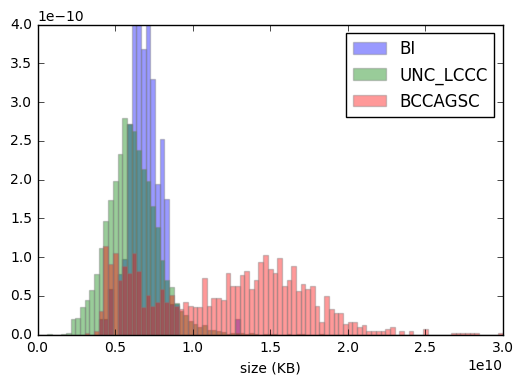

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111)

bins = np.linspace(0, 3e10, 100)
ax.hist(bi_df.objectSizeBytes.values, bins=bins, normed=True, alpha=0.4, ec='grey', label='BI')
ax.hist(unc_df.objectSizeBytes.values, bins=bins, normed=True, alpha=0.4, ec='grey', label='UNC_LCCC')
ax.hist(gsc_df.objectSizeBytes.values, bins=bins, normed=True, alpha=0.4, ec='grey', label='BCCAGSC')
ax.legend()
ax.set_xlabel('size (KB)')